## This notebook assesses the performance of CRANE by analysing the peptide and protein data

### For this notebook to work,
 * the csv files from ProteomeXchange (Identifier—PXD020529) with peptide data needs to be saved in a subdirectory called peptide_n_protein_data
 * diffacto version 1.0.5 needs to be copied to a subdirectory called diffacto (https://github.com/statisticalbiotechnology/diffacto)

In [1]:
import os
import math
import datetime
from scipy.stats import levene
from scipy.stats import ttest_1samp

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Create output files
if os.path.isdir('figures') == False:
    !mkdir figures
if os.path.isdir('peptide_n_protein_data/stats') == False:
    !mkdir peptide_n_protein_data/stats
if os.path.isdir('peptide_n_protein_data/diffacto_files') == False:
    !mkdir peptide_n_protein_data/diffacto_files

In [3]:
# In order to compare quntification of the different tools on an equal footing we can
# perform quantification analysis only on the common peptides and proteins
filter_common_peptides = True
filter_common_proteins = True

In [4]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Combine datasets (OSW-BS0, OSW-BS1 and CRANE)

In [5]:
raw_osw_bs0_pqm_data = pd.read_csv('peptide_n_protein_data/multicenter_RAW_OSW0_peptide_data.csv')
raw_osw_bs1_pqm_data = pd.read_csv('peptide_n_protein_data/multicenter_RAW_OSW1_peptide_data.csv')
crane_osw_bs0_pqm_data = pd.read_csv('peptide_n_protein_data/multicenter_CRANE_OSW0_peptide_data.csv')
crane_osw_bs1_pqm_data = pd.read_csv('peptide_n_protein_data/multicenter_CRANE_OSW1_peptide_data.csv')

raw_osw_bs0_pqm_data['Type'] = 'RAW_OSW0'
raw_osw_bs1_pqm_data['Type'] = 'RAW_OSW1'
crane_osw_bs0_pqm_data['Type'] = 'CRANE_OSW0'
crane_osw_bs1_pqm_data['Type'] = 'CRANE_OSW1'

all_data = pd.concat(
    [
        raw_osw_bs0_pqm_data,
        raw_osw_bs1_pqm_data,
        crane_osw_bs0_pqm_data,
        crane_osw_bs1_pqm_data,
    ], sort=False
)

# Define hue order
Reference = 'RAW_OSW0'
hue_order = ['RAW_OSW0', 'RAW_OSW1', 'CRANE_OSW0', 'CRANE_OSW1']
hue_order_less_ref = ['RAW_OSW1', 'CRANE_OSW0', 'CRANE_OSW1']

# Convert PQM to peptide
all_data = all_data.groupby(['Type', 'sample_key', 'Protein', 'Peptide', 'ModifiedPeptide'])[['Intensity']].sum().replace(0,np.nan).reset_index()
all_data['Intensity (log2)'] = all_data.Intensity.apply(np.log2)
all_data['Species'] = all_data.Protein.apply(lambda x: x.split('_')[-1])
all_data.loc[all_data.Species == 'YEAS8', 'Species'] = 'YEAST'
all_data.head()

,Type,sample_key,Protein,Peptide,ModifiedPeptide,Intensity,Intensity (log2),Species
0,CRANE_OSW0,hye110_ttof6600_32fix_lgillet_i160308_001,1/sp|A0FGR8|ESYT2_HUMAN,VGNQIFQSR,VGNQIFQSR,NaN,NaN,HUMAN
1,CRANE_OSW0,hye110_ttof6600_32fix_lgillet_i160308_001,1/sp|A1L0T0|ILVBL_HUMAN,GALQAVDQLSLFRPLCK,GALQAVDQLSLFRPLC(UniMod:4)K,8640.0,13.076816,HUMAN
2,CRANE_OSW0,hye110_ttof6600_32fix_lgillet_i160308_001,1/sp|A5YKK6|CNOT1_HUMAN,SLDLIESLLR,SLDLIESLLR,14171.0,13.790654,HUMAN
3,CRANE_OSW0,hye110_ttof6600_32fix_lgillet_i160308_001,1/sp|A6NDG6|PGP_HUMAN,AVVVGFDPHFSYMK,AVVVGFDPHFSYMK,13007.0,13.667001,HUMAN
4,CRANE_OSW0,hye110_ttof6600_32fix_lgillet_i160308_001,1/sp|A6NDG6|PGP_HUMAN,FIAGTGCLVR,FIAGTGC(UniMod:4)LVR,NaN,NaN,HUMAN


In [6]:
file_details = pd.DataFrame(
    np.array(
        [["HYE124_TTOF5600_32fix", "lgillet_L150206_001", "lgillet_L150206_003", "lgillet_L150206_005", "A"], 
         ["HYE124_TTOF5600_32fix", "lgillet_L150206_002", "lgillet_L150206_013", "lgillet_L150206_014", "B"], 
         ["HYE124_TTOF5600_64var", "lgillet_L150206_007", "lgillet_L150206_009", "lgillet_L150206_011", "A"],
         ["HYE124_TTOF5600_64var", "lgillet_L150206_008", "lgillet_L150206_010", "lgillet_L150206_012", "B"],
         ["HYE124_TTOF6600_32fix", "lgillet_I150211_002", "lgillet_I150211_004", "lgillet_I150211_006", "A"],
         ["HYE124_TTOF6600_32fix", "lgillet_I150211_003", "lgillet_I150211_005", "lgillet_I150211_007", "B"],
         ["HYE124_TTOF6600_64var", "lgillet_I150211_008", "lgillet_I150211_010", "lgillet_I150211_012", "A"],
         ["HYE124_TTOF6600_64var", "lgillet_I150211_009", "lgillet_I150211_011", "lgillet_I150211_013", "B"],
         ["HYE110_TTOF6600_32fix", "lgillet_I160308_001", "lgillet_I160308_003", "lgillet_I160308_010", "A"],
         ["HYE110_TTOF6600_32fix", "lgillet_I160308_002", "lgillet_I160308_004", "lgillet_I160308_011", "B"],
         ["HYE110_TTOF6600_32var", "lgillet_I160309_001", "lgillet_I160309_003", "lgillet_I160309_005", "A"],
         ["HYE110_TTOF6600_32var", "lgillet_I160309_002", "lgillet_I160309_004", "lgillet_I160309_006", "B"],
         ["HYE110_TTOF6600_64fix", "lgillet_I160310_001", "lgillet_I160310_003", "lgillet_I160310_005", "A"],
         ["HYE110_TTOF6600_64fix", "lgillet_I160310_002", "lgillet_I160310_004", "lgillet_I160310_006", "B"],
         ["HYE110_TTOF6600_64var", "lgillet_I160305_001", "lgillet_I160305_003", "lgillet_I160305_005", "A"],
         ["HYE110_TTOF6600_64var", "lgillet_I160305_002", "lgillet_I160305_004", "lgillet_I160305_006", "B"]]
    ), 
    columns=['Prefix', 'Rep1', 'Rep2', 'Rep3', 'Sample']
)

In [7]:
file_details['Prefix'] = file_details.Prefix.str.lower()
file_details = file_details.set_index(['Prefix', 'Sample']).stack().reset_index()
file_details.rename(columns={'level_2':'Replication', 0:'Suffix'}, inplace=True)
file_details['Suffix'] = file_details.Suffix.str.lower()
file_details['Replication'] = file_details.Replication.apply(lambda x: x[-1:])
file_details['FileName'] = file_details['Prefix'] + '_' +file_details['Suffix']
file_details['Experiment'] = file_details.Prefix.apply(lambda x: x.split('_')[0])
file_details['Machine'] = file_details.Prefix.apply(lambda x: x.split('_')[1])
file_details['Machine'] = file_details['Machine'].str.upper() 
file_details['WindowSetup'] = file_details.Prefix.apply(lambda x: x.split('_')[2])
file_details.drop(columns=['Prefix', 'Suffix'], inplace=True)

In [8]:
all_data = pd.merge(all_data, file_details, left_on='sample_key',right_on='FileName',how='inner')
all_data.drop(columns=['FileName'], inplace=True)
all_data.head()

,Type,sample_key,Protein,Peptide,ModifiedPeptide,Intensity,Intensity (log2),Species,Sample,Replication,Experiment,Machine,WindowSetup
0,CRANE_OSW0,hye110_ttof6600_32fix_lgillet_i160308_001,1/sp|A0FGR8|ESYT2_HUMAN,VGNQIFQSR,VGNQIFQSR,NaN,NaN,HUMAN,A,1,hye110,TTOF6600,32fix
1,CRANE_OSW0,hye110_ttof6600_32fix_lgillet_i160308_001,1/sp|A1L0T0|ILVBL_HUMAN,GALQAVDQLSLFRPLCK,GALQAVDQLSLFRPLC(UniMod:4)K,8640.0,13.076816,HUMAN,A,1,hye110,TTOF6600,32fix
2,CRANE_OSW0,hye110_ttof6600_32fix_lgillet_i160308_001,1/sp|A5YKK6|CNOT1_HUMAN,SLDLIESLLR,SLDLIESLLR,14171.0,13.790654,HUMAN,A,1,hye110,TTOF6600,32fix
3,CRANE_OSW0,hye110_ttof6600_32fix_lgillet_i160308_001,1/sp|A6NDG6|PGP_HUMAN,AVVVGFDPHFSYMK,AVVVGFDPHFSYMK,13007.0,13.667001,HUMAN,A,1,hye110,TTOF6600,32fix
4,CRANE_OSW0,hye110_ttof6600_32fix_lgillet_i160308_001,1/sp|A6NDG6|PGP_HUMAN,FIAGTGCLVR,FIAGTGC(UniMod:4)LVR,NaN,NaN,HUMAN,A,1,hye110,TTOF6600,32fix


### Median Normalization

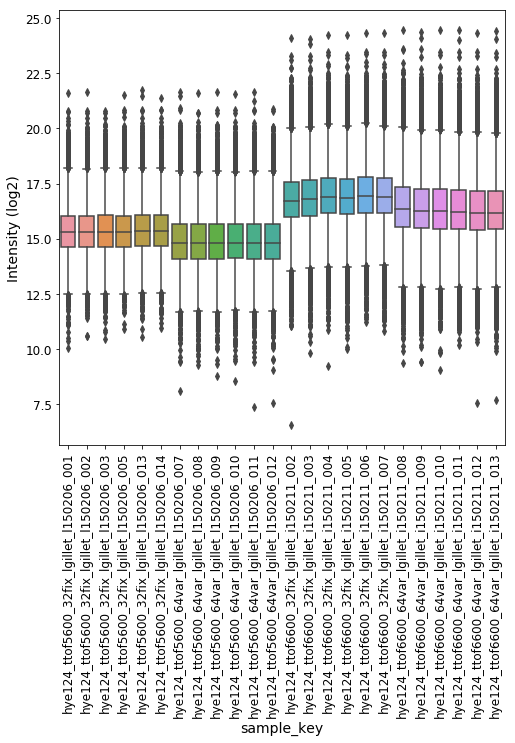

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
sns.boxplot(
    data=all_data.loc[(all_data.Experiment == 'hye124') & (all_data.Type == Reference) & (all_data.Species == 'HUMAN')],
    x='sample_key',
    y='Intensity (log2)',
    ax=axs
)
axs.tick_params('x', labelrotation=90)
plt.show()

In [10]:
all_data['Normalized Intensity (log2)'] = np.nan
columns = all_data.columns.values
normalised_data = pd.DataFrame(columns=columns)
experiemnt_list = all_data.Experiment.unique().tolist()
for experiemnt in experiemnt_list:
    temp = all_data.loc[all_data.Experiment == experiemnt]
    type_list = temp.Type.unique().tolist()
    for typ in type_list:
        temp2 = temp.loc[temp.Type == typ]
        temp3 = temp2.loc[temp2.Species == 'HUMAN']
        normalization_factor = temp3.groupby('sample_key')['Intensity (log2)'].median().reset_index()
        normalization_factor = normalization_factor.rename(columns = {'Intensity (log2)': 'log2 Median Intensity'})
        ref_median = np.median(normalization_factor['log2 Median Intensity'].tolist())
        normalization_factor['normalization_factor'] = normalization_factor['log2 Median Intensity'] - ref_median
        temp2 = pd.merge(temp2, normalization_factor, left_on='sample_key',right_on='sample_key',how='inner')
        temp2['Normalized Intensity (log2)'] = temp2['Intensity (log2)'] - temp2['normalization_factor']
        normalised_data = normalised_data.append(temp2[columns], ignore_index=True)

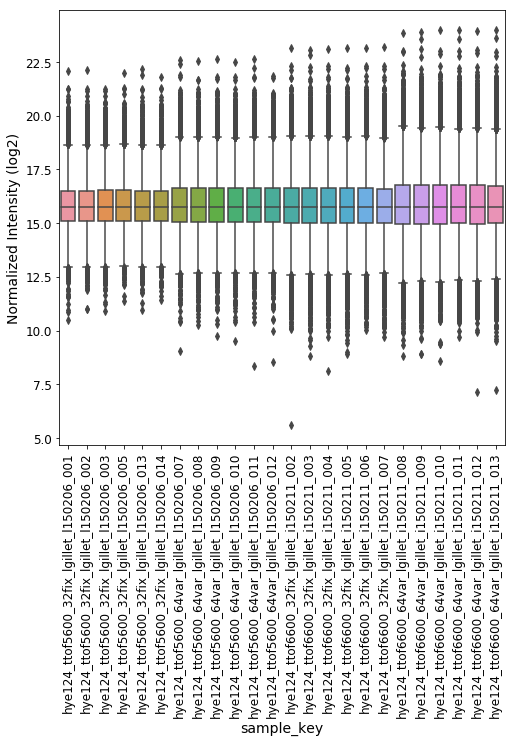

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
sns.boxplot(
    data=normalised_data.loc[(normalised_data.Experiment == 'hye124') & (normalised_data.Type == Reference) & (normalised_data.Species == 'HUMAN')],
    x='sample_key',
    y='Normalized Intensity (log2)',
    ax=axs
)
axs.tick_params('x', labelrotation=90)
plt.show()

In [12]:
normalised_data = normalised_data.dropna(subset=['Normalized Intensity (log2)'])
normalised_data['Normalized Intensity'] = normalised_data['Normalized Intensity (log2)'].apply(np.exp2)

### Define colour palette

In [13]:
palette=sns.color_palette('Set2')
palette_less_ref=palette[1:]

## CV before normalization

In [14]:
variance = all_data.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'ModifiedPeptide'])['Intensity'].std().to_frame()
variance.reset_index(inplace=True)
variance = variance.rename(columns={'Intensity': 'Standard_deviation'})

In [15]:
mean = all_data.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'ModifiedPeptide'])['Intensity'].mean().to_frame()
mean.reset_index(inplace=True)
mean = mean.rename(columns={'Intensity': 'Mean'})

In [16]:
all_peptide_cv = variance.merge(mean, how = 'inner')
all_peptide_cv = all_peptide_cv.dropna()
all_peptide_cv['CV'] = 100* all_peptide_cv['Standard_deviation'] / all_peptide_cv['Mean']
all_peptide_cv['CV (log10)'] = all_peptide_cv.CV.apply(np.log10)
all_peptide_cv['Group_by'] = all_peptide_cv['Machine'] + '_' + all_peptide_cv['WindowSetup']

Text(0.5,0.98,'Peptide CV of Before Normalization')

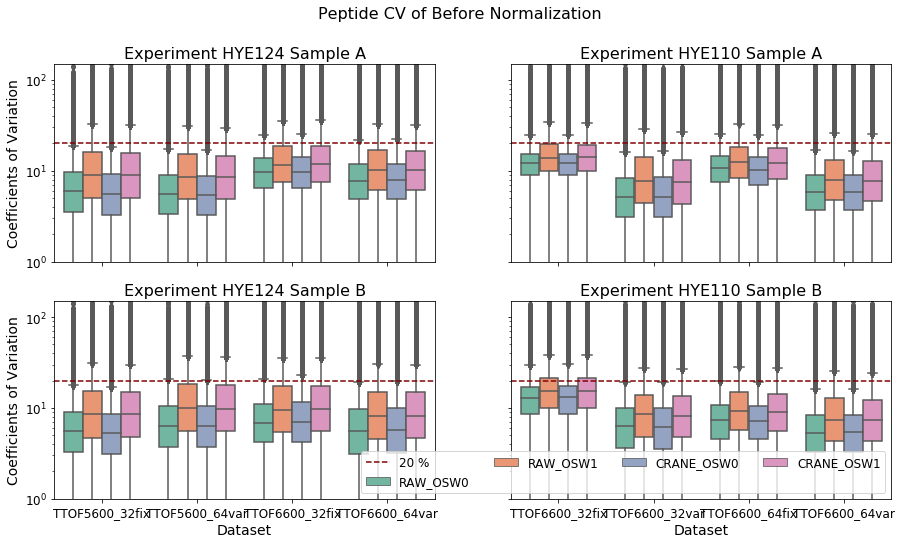

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
sns.boxplot(
    data=all_peptide_cv.loc[(all_peptide_cv.Experiment == 'hye124') & (all_peptide_cv.Sample == 'A')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0,0],
)
axs[0,0].set_title('Experiment HYE124 Sample A')
axs[0,0].set_xlabel('Dataset')
axs[0,0].set_ylabel('Coefficients of Variation')
axs[0,0].set_yscale('log')
axs[0,0].axhline(20, ls='--', c='maroon', label='20 %')
axs[0,0].set_ylim((1, 150))
axs[0,0].get_legend().remove()

sns.boxplot(
    data=all_peptide_cv.loc[(all_peptide_cv.Experiment == 'hye124') & (all_peptide_cv.Sample == 'B')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1,0],
)
axs[1,0].set_title('Experiment HYE124 Sample B')
axs[1,0].set_xlabel('Dataset')
axs[1,0].set_ylabel('Coefficients of Variation')
axs[1,0].set_yscale('log')
axs[1,0].axhline(20, ls='--', c='maroon', label='20 %')
axs[1,0].set_ylim((1, 150))
axs[1,0].get_legend().remove()

sns.boxplot(
    data=all_peptide_cv.loc[(all_peptide_cv.Experiment == 'hye110') & (all_peptide_cv.Sample == 'A')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0,1],
)
axs[0,1].set_title('Experiment HYE110 Sample A')
axs[0,1].set_xlabel('Dataset')
axs[0,1].set_ylabel('Coefficients of Variation')
axs[0,1].set_yscale('log')
axs[0,1].axhline(20, ls='--', c='maroon', label='20 %')
axs[0,1].set_ylim((1, 150))
axs[0,1].get_legend().remove()

sns.boxplot(
    data=all_peptide_cv.loc[(all_peptide_cv.Experiment == 'hye110') & (all_peptide_cv.Sample == 'B')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1,1],
)
axs[1,1].set_title('Experiment HYE110 Sample B')
axs[1,1].set_xlabel('Dataset')
axs[1,1].set_ylabel('Coefficients of Variation')
axs[1,1].set_yscale('log')
axs[1,1].axhline(20, ls='--', c='maroon', label='20 %')
axs[1,1].set_ylim((1, 150))


plt.legend(loc='lower right', ncol = 4)

for ax in axs.flat:
    ax.label_outer()
plt.suptitle('Peptide CV of Before Normalization')

## CV after normalization

In [18]:
variance2 = normalised_data.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'ModifiedPeptide'])['Normalized Intensity'].std().to_frame()
variance2.reset_index(inplace=True)
variance2 = variance2.rename(columns={'Normalized Intensity': 'Standard_deviation'})

In [19]:
mean2 = normalised_data.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'ModifiedPeptide'])['Normalized Intensity'].mean().to_frame()
mean2.reset_index(inplace=True)
mean2 = mean2.rename(columns={'Normalized Intensity': 'Mean'})

In [20]:
all_peptide_cv2 = variance2.merge(mean2, how = 'inner')
all_peptide_cv2 = all_peptide_cv2.dropna()
all_peptide_cv2['CV'] = 100* all_peptide_cv2['Standard_deviation'] / all_peptide_cv2['Mean']
all_peptide_cv2['CV (log10)'] = all_peptide_cv2.CV.apply(np.log10)
all_peptide_cv2['Group_by'] = all_peptide_cv2['Machine'] + '_' + all_peptide_cv2['WindowSetup']

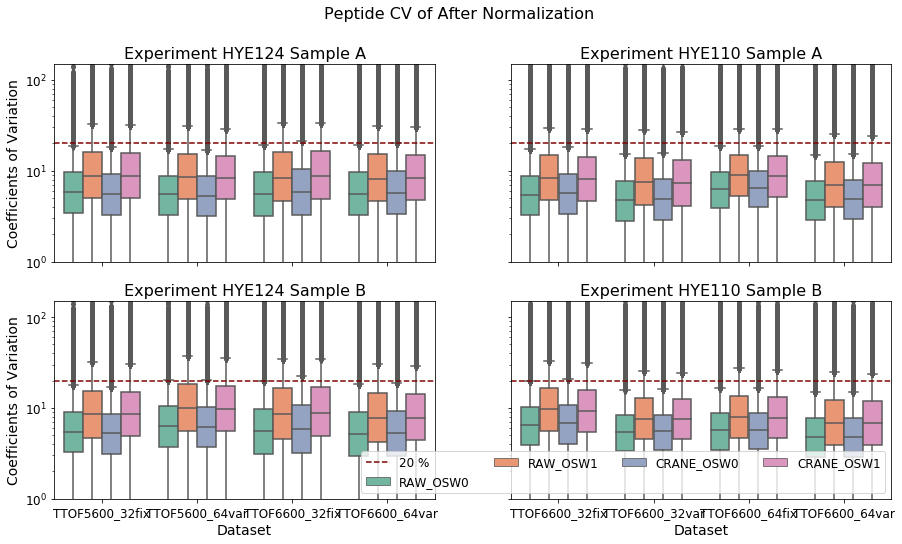

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
sns.boxplot(
    data=all_peptide_cv2.loc[(all_peptide_cv2.Experiment == 'hye124') & (all_peptide_cv2.Sample == 'A')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0,0],
)
axs[0,0].set_title('Experiment HYE124 Sample A')
axs[0,0].set_xlabel('Dataset')
axs[0,0].set_ylabel('Coefficients of Variation')
axs[0,0].set_yscale('log')
axs[0,0].axhline(20, ls='--', c='maroon', label='20 %')
axs[0,0].set_ylim((1, 150))
axs[0,0].get_legend().remove()

sns.boxplot(
    data=all_peptide_cv2.loc[(all_peptide_cv2.Experiment == 'hye124') & (all_peptide_cv2.Sample == 'B')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1,0],
)
axs[1,0].set_title('Experiment HYE124 Sample B')
axs[1,0].set_xlabel('Dataset')
axs[1,0].set_ylabel('Coefficients of Variation')
axs[1,0].set_yscale('log')
axs[1,0].axhline(20, ls='--', c='maroon', label='20 %')
axs[1,0].set_ylim((1, 150))
axs[1,0].get_legend().remove()

sns.boxplot(
    data=all_peptide_cv2.loc[(all_peptide_cv2.Experiment == 'hye110') & (all_peptide_cv2.Sample == 'A')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0,1],
)
axs[0,1].set_title('Experiment HYE110 Sample A')
axs[0,1].set_xlabel('Dataset')
axs[0,1].set_ylabel('Coefficients of Variation')
axs[0,1].set_yscale('log')
axs[0,1].axhline(20, ls='--', c='maroon', label='20 %')
axs[0,1].set_ylim((1, 150))
axs[0,1].get_legend().remove()

sns.boxplot(
    data=all_peptide_cv2.loc[(all_peptide_cv2.Experiment == 'hye110') & (all_peptide_cv2.Sample == 'B')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1,1],
)
axs[1,1].set_title('Experiment HYE110 Sample B')
axs[1,1].set_xlabel('Dataset')
axs[1,1].set_ylabel('Coefficients of Variation')
axs[1,1].set_yscale('log')
axs[1,1].axhline(20, ls='--', c='maroon', label='20 %')
axs[1,1].set_ylim((1, 150))

for ax in axs.flat:
    ax.label_outer()
plt.suptitle('Peptide CV of After Normalization')
plt.legend(loc='lower right', ncol = 4)

### Store peptide CV stats

In [22]:
cv_bn_median = all_peptide_cv2.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species'])['CV'].median().to_frame()
cv_bn_median.reset_index(inplace=True)
cv_bn_median = cv_bn_median.rename(columns={'CV': 'Peptide_CV_Median'})
cv_bn_variance = all_peptide_cv2.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species'])['CV'].std().to_frame()
cv_bn_variance.reset_index(inplace=True)
cv_bn_variance = cv_bn_variance.rename(columns={'CV': 'Peptide_CV_STD'})
peptide_stats = cv_bn_variance.merge(cv_bn_median, how = 'inner')
peptide_stats.head()

,Type,Experiment,Machine,WindowSetup,Species,Peptide_CV_STD,Peptide_CV_Median
0,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,12.458811,6.789764
1,CRANE_OSW0,hye110,TTOF6600,32fix,HUMAN,11.384726,6.032709
2,CRANE_OSW0,hye110,TTOF6600,32fix,YEAST,13.020334,6.087407
3,CRANE_OSW0,hye110,TTOF6600,32var,ECOLI,11.570059,5.746380
4,CRANE_OSW0,hye110,TTOF6600,32var,HUMAN,9.575996,4.917382


## Compare number of peptide IDs

In [23]:
species_peptide_count = normalised_data.groupby(['sample_key', 'Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'Replication'])[['Normalized Intensity (log2)']].count().reset_index()
species_peptide_count.rename(columns={'Normalized Intensity (log2)': 'peptide_count'}, inplace=True)
median_species_peptide_count = species_peptide_count.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species'])[['peptide_count']].median().reset_index()
median_species_peptide_count.rename(columns={'peptide_count': 'Median_Peptide_Count'}, inplace=True)


In [24]:
Peptide_Detection_Improvement = pd.DataFrame(columns=['sample_key', 'Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'Replication', 'Peptide_Detection_Improvement'])
sample_key_list = species_peptide_count.sample_key.unique().tolist()
for sample_key in sample_key_list:
    temp = species_peptide_count.loc[species_peptide_count.sample_key == sample_key]
    species_list = temp.Species.unique().tolist()
    for species in species_list:
        temp2 = temp.loc[temp.Species == species]
        ref_pep_count = temp2.loc[temp2.Type ==Reference]['peptide_count'].values.tolist()[0]
        type_list = temp2.Type.unique().tolist()
        for typ in type_list:
            if typ != Reference:
                temp3 = temp2.loc[temp2.Type == typ]
                pep_count = temp3['peptide_count'].values.tolist()[0]
                peptide_improvement = (pep_count - ref_pep_count)/ref_pep_count * 100
                Peptide_Detection_Improvement = Peptide_Detection_Improvement.append(
                    {
                        'sample_key':sample_key,
                        'Type': typ,
                        'Experiment':temp3.Experiment.tolist()[0],
                        'Machine':temp3.Machine.tolist()[0],
                        'WindowSetup':temp3.WindowSetup.tolist()[0],
                        'Sample': temp3.Sample.tolist()[0],
                        'Species': species,
                        'Replication':temp3.Replication.tolist()[0],
                        'Peptide_Detection_Improvement':peptide_improvement
                    },
                    ignore_index=True
                )
Peptide_Detection_Improvement['Group_by'] = Peptide_Detection_Improvement['Machine'] + '_' +Peptide_Detection_Improvement['WindowSetup']

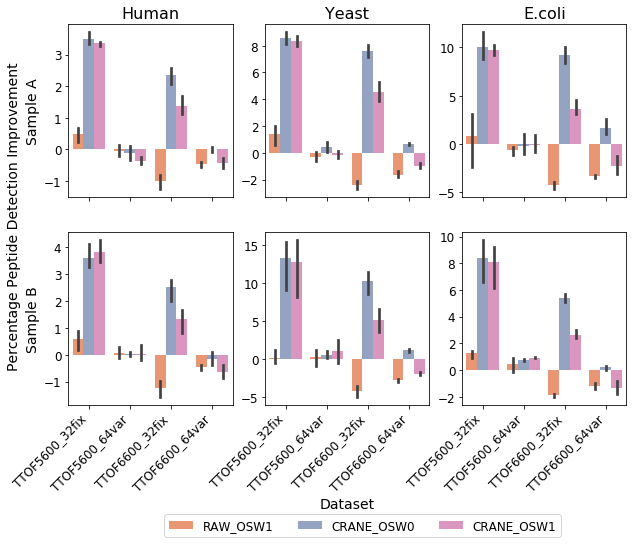

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex='col')

species_list = ['HUMAN', 'YEAST', 'ECOLI']
species_list2 = ['Human', 'Yeast', 'E.coli']
for i in range(len(species_list)):
    temp = Peptide_Detection_Improvement.loc[(Peptide_Detection_Improvement.Experiment == 'hye124') & (Peptide_Detection_Improvement.Species == species_list[i])]

    sns.barplot(
        data=temp.loc[(temp.Sample == 'A')],
        x='Group_by',
        y='Peptide_Detection_Improvement',
        hue='Type',
        hue_order=hue_order_less_ref,
        palette=palette_less_ref,
        ax=axs[0,i],
    )
    axs[0,i].set_title('{}'.format(species_list2[i]))
    axs[0,i].set_xlabel('')
    if i == 0:
        axs[0,i].set_ylabel('Sample A')
    else:
        axs[0,i].set_ylabel('')
    axs[0,i].get_legend().remove()
    axs[0,i].tick_params('x', labelrotation=45) 


    sns.barplot(
        data=temp.loc[(temp.Sample == 'B')],
        x='Group_by',
        y='Peptide_Detection_Improvement',
        hue='Type',
        hue_order=hue_order_less_ref,
        palette=palette_less_ref,
        ax=axs[1,i],
    )
    if i == 1:
        axs[1,i].set_xlabel('Dataset')
    else:
        axs[1,i].set_xlabel('')
    if i == 0:
        axs[1,i].set_ylabel('Sample B')
    else:
        axs[1,i].set_ylabel('')
    axs[1,i].get_legend().remove()
    axs[1,i].tick_params('x', labelrotation=45) 
    for tick in axs[1,i].xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")
    
axs[1,0].legend(bbox_to_anchor=(0.25,-0.08), loc="upper left",  bbox_transform=fig.transFigure, ncol = 4)
fig.text(0.04, 0.5, 'Percentage Peptide Detection Improvement', va='center', rotation='vertical', fontsize =14)
# plt.suptitle('Peptide Detection of Experiment HYE124')
plt.savefig('figures/Experiment_124_peptide_ID_stats_per_species.eps', dpi=350, format='eps', bbox_inches='tight')

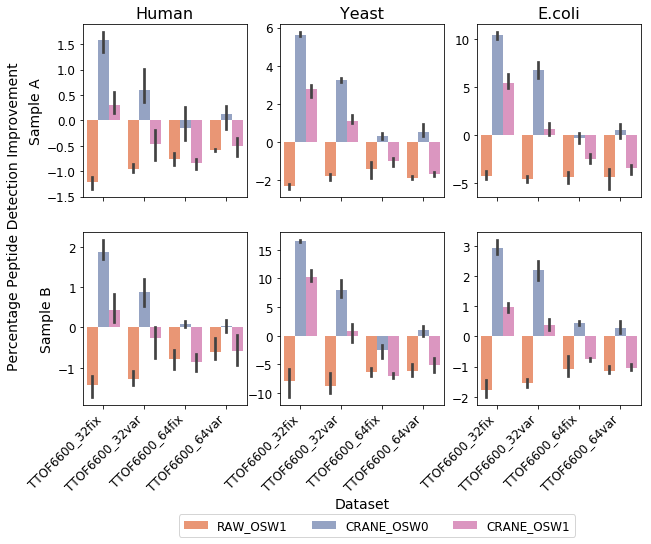

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex='col')

species_list = ['HUMAN', 'YEAST', 'ECOLI']
species_list2 = ['Human', 'Yeast', 'E.coli']
for i in range(len(species_list)):
    temp = Peptide_Detection_Improvement.loc[(Peptide_Detection_Improvement.Experiment == 'hye110') & (Peptide_Detection_Improvement.Species == species_list[i])]

    sns.barplot(
        data=temp.loc[(temp.Sample == 'A')],
        x='Group_by',
        y='Peptide_Detection_Improvement',
        hue='Type',
        hue_order=hue_order_less_ref,
        palette=palette_less_ref,
        ax=axs[0,i],
    )
    axs[0,i].set_title('{}'.format(species_list2[i]))
    axs[0,i].set_xlabel('')
    if i == 0:
        axs[0,i].set_ylabel('Sample A')
    else:
        axs[0,i].set_ylabel('')
    axs[0,i].get_legend().remove()
    axs[0,i].tick_params('x', labelrotation=45) 


    sns.barplot(
        data=temp.loc[(temp.Sample == 'B')],
        x='Group_by',
        y='Peptide_Detection_Improvement',
        hue='Type',
        hue_order=hue_order_less_ref,
        palette=palette_less_ref,
        ax=axs[1,i],
    )
    if i == 1:
        axs[1,i].set_xlabel('Dataset')
    else:
        axs[1,i].set_xlabel('')
    if i == 0:
        axs[1,i].set_ylabel('Sample B')
    else:
        axs[1,i].set_ylabel('')
    axs[1,i].get_legend().remove()
    axs[1,i].tick_params('x', labelrotation=45) 
    for tick in axs[1,i].xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")
    
axs[1,0].legend(bbox_to_anchor=(0.25,-0.08), loc="upper left",  bbox_transform=fig.transFigure, ncol = 4)
fig.text(0.02, 0.5, 'Percentage Peptide Detection Improvement', va='center', rotation='vertical', fontsize =14)
# plt.suptitle('Peptide Detection of Experiment HYE110')
plt.savefig('figures/Experiment_110_peptide_ID_stats_per_species.eps', dpi=350, format='eps', bbox_inches='tight')

### Store peptide count stats

In [27]:
peptide_stats = peptide_stats.merge(median_species_peptide_count, how = 'inner')
Median_Peptide_Detection_Improvement = Peptide_Detection_Improvement.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species'])[['Peptide_Detection_Improvement']].median().reset_index()
Median_Peptide_Detection_Improvement.rename(columns={'Peptide_Detection_Improvement': 'Median_Peptide_Detection_Improvement'}, inplace=True)
peptide_stats = peptide_stats.merge(Median_Peptide_Detection_Improvement, how = 'left')
peptide_stats.head()

,Type,Experiment,Machine,WindowSetup,Species,Peptide_CV_STD,Peptide_CV_Median,Sample,Median_Peptide_Count,Median_Peptide_Detection_Improvement
0,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,12.458811,6.789764,A,2197,10.526316
1,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,12.458811,6.789764,B,7900,2.891378
2,CRANE_OSW0,hye110,TTOF6600,32fix,HUMAN,11.384726,6.032709,A,11149,1.657008
3,CRANE_OSW0,hye110,TTOF6600,32fix,HUMAN,11.384726,6.032709,B,11289,1.728616
4,CRANE_OSW0,hye110,TTOF6600,32fix,YEAST,13.020334,6.087407,A,6092,5.558469


## Deviations from expected abundance ratios

In [28]:
averaged_normalized_data = normalised_data.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'Protein', 'Peptide', 'ModifiedPeptide'])['Normalized Intensity (log2)'].mean().reset_index()
averaged_normalized_data['Abundance Ratios (log2)'] = np.nan
columns = list (averaged_normalized_data.columns.values)
columns.append('Intensity B (log2)')
columns = np.asarray(columns)
abundance_ratios = pd.DataFrame(columns=columns)
experiemnt_list = averaged_normalized_data.Experiment.unique().tolist()
for experiemnt in experiemnt_list:
    temp = averaged_normalized_data.loc[averaged_normalized_data.Experiment == experiemnt]
    machine_list = temp.Machine.unique().tolist()
    for machine in machine_list:
        temp2 = temp.loc[temp.Machine == machine]
        window_list = temp2.WindowSetup.unique().tolist() 
        for window in window_list:
            temp3 = temp2.loc[temp2.WindowSetup == window]
            type_list = temp3.Type.unique().tolist()
            for typ in type_list:
                a_sample = temp3.loc[
                    (temp3.Type == typ) &
                    (temp3.Sample == 'A')
                ]
                b_sample = temp3.loc[
                    (temp3.Type == typ) &
                    (temp3.Sample == 'B')
                ]
                a_sample = a_sample.dropna(subset=['Normalized Intensity (log2)'])
                b_sample = b_sample.dropna(subset=['Normalized Intensity (log2)'])
                b_sample = b_sample[['ModifiedPeptide', 'Normalized Intensity (log2)']]
                b_sample = b_sample.rename(columns={'Normalized Intensity (log2)': 'Intensity B (log2)'})
                a_sample = a_sample.merge(b_sample, how='inner')
                a_sample['Abundance Ratios (log2)'] = a_sample['Normalized Intensity (log2)'] - a_sample['Intensity B (log2)']
                a_sample = a_sample[columns]
                abundance_ratios = abundance_ratios.append(a_sample, ignore_index=True)
abundance_ratios = abundance_ratios.rename(columns={'Normalized Intensity (log2)': 'Intensity A (log2)'})
abundance_ratios.drop(columns=['Sample'], inplace=True)
abundance_ratios['Group_by'] = abundance_ratios['Machine'] + '_' + abundance_ratios['WindowSetup']

In [29]:
abundance_ratios.head()

,Type,Experiment,Machine,WindowSetup,Species,Protein,Peptide,ModifiedPeptide,Intensity A (log2),Abundance Ratios (log2),Intensity B (log2),Group_by
0,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,1/sp|P00350|6PGD_ECOLI,AASEEYNWDLNYGEIAK,AASEEYNWDLNYGEIAK,12.221900,-1.665101,13.887001,TTOF6600_32fix
1,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,1/sp|P00350|6PGD_ECOLI,AAVLPANLIQAQR,AAVLPANLIQAQR,15.010739,-2.918851,17.929590,TTOF6600_32fix
2,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,1/sp|P00350|6PGD_ECOLI,EAYELVAPILTK,EAYELVAPILTK,10.452171,-2.701132,13.153303,TTOF6600_32fix
3,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,1/sp|P00350|6PGD_ECOLI,EFVESLETPRR,EFVESLETPRR,13.435306,-3.234894,16.670200,TTOF6600_32fix
4,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,1/sp|P00350|6PGD_ECOLI,ELSAEGFNFIGTGVSGGEEGALKGPSIMPGGQK,ELSAEGFNFIGTGVSGGEEGALKGPSIMPGGQK,11.430163,-1.885427,13.315591,TTOF6600_32fix


In [30]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
 
sns.boxplot(
    data=abundance_ratios.loc[(abundance_ratios.Experiment == 'hye124') & (abundance_ratios.Species == 'HUMAN')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0],
)
axs[0].set_title('Human Peptides')
axs[0].plot([-0.5, 3.5], [np.log2(1)] * 2, ls='--', c='maroon')
axs[0].get_legend().remove()
axs[0].set_ylim((-1.5, 1.5))
axs[0].set_ylabel('Abundance Ratios / log2(A:B)')
axs[0].set_xlabel('Dataset')

sns.boxplot(
    data=abundance_ratios.loc[(abundance_ratios.Experiment == 'hye124') & (abundance_ratios.Species == 'ECOLI')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1],
)
axs[1].set_title('Ecoli Peptides')
axs[1].plot([-0.5, 3.5], [np.log2(1/4)] * 2, ls='--', c='maroon')
axs[1].get_legend().remove()
axs[1].set_ylim((-4, 1))
axs[1].set_ylabel('Abundance Ratios / log2(A:B)')
axs[1].set_xlabel('Dataset')

sns.boxplot(
    data=abundance_ratios.loc[(abundance_ratios.Experiment == 'hye124') & (abundance_ratios.Species == 'YEAST')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[2],
)
axs[2].set_title('Yeast Peptides')
axs[2].plot([-0.5, 3.5], [np.log2(2)] * 2, ls='--', c='maroon')
axs[2].legend(bbox_to_anchor=(0.02, 0.08), loc="upper left",  bbox_transform=fig.transFigure, ncol = 4)
axs[2].set_ylim((-0.5, 2))
axs[2].set_ylabel('Abundance Ratios / log2(A:B)')
axs[2].set_xlabel('Dataset')
for ax in axs.flat:
    ax.label_outer()

# plt.suptitle('Peptide Abundance Ratio of Experiment HYE124', y=0.95)
plt.savefig('figures/Experiment_124_peptide_abundance_ratio_box_plots.eps', dpi=350, format='eps', bbox_inches='tight')

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
 
sns.boxplot(
    data=abundance_ratios.loc[(abundance_ratios.Experiment == 'hye110') & (abundance_ratios.Species == 'HUMAN')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0],
)
axs[0].set_title('Human Peptides')
axs[0].plot([-0.5, 3.5], [0] * 2, ls='--', c='maroon')
axs[0].get_legend().remove()
axs[0].set_ylim((-1.5, 1.5))
axs[0].set_ylabel('Abundance Ratios / log2(A:B)')
axs[0].set_xlabel('Dataset')

sns.boxplot(
    data=abundance_ratios.loc[(abundance_ratios.Experiment == 'hye110') & (abundance_ratios.Species == 'ECOLI')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1],
)
axs[1].set_title('Ecoli Peptides')
axs[1].plot([-0.5, 3.5], [np.log2(3/30)] * 2, ls='--', c='maroon')
axs[1].get_legend().remove()
axs[1].set_ylim((-6, 1))
axs[1].set_ylabel('Abundance Ratios / log2(A:B)')
axs[1].set_xlabel('Dataset')

sns.boxplot(
    data=abundance_ratios.loc[(abundance_ratios.Experiment == 'hye110') & (abundance_ratios.Species == 'YEAST')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[2],
)
axs[2].set_title('Yeast Peptides')
axs[2].plot([-0.5, 3.5], [np.log2(30/3)] * 2, ls='--', c='maroon')
axs[2].legend(bbox_to_anchor=(0.02, 0.08), loc="upper left",  bbox_transform=fig.transFigure, ncol = 4)
axs[2].set_ylim((-2, 7))
axs[2].set_ylabel('Abundance Ratios / log2(A:B)')
axs[2].set_xlabel('Dataset')
for ax in axs.flat:
    ax.label_outer()

# plt.suptitle('Peptide Abundance Ratio of Experiment HYE110', y=0.95)
plt.savefig('figures/Experiment_110_peptide_abundance_ratio_box_plots.eps', dpi=350, format='eps', bbox_inches='tight')

### Calculate species seperation arctanh measure

In [32]:
peptide_abundance_ratio_species_seperation = pd.DataFrame(columns=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Peptide_Overlap_Yeast_Human_arctanh', 'Peptide_Overlap_E_Coli_Human_arctanh'])
columns = abundance_ratios.columns.values
filtered_abundance_ratios = pd.DataFrame(columns=columns)
threshold_range = np.linspace(-5, 5, 201)
experiment_list = abundance_ratios.Experiment.unique().tolist()
for experiment in experiment_list:
    temp = abundance_ratios.loc[abundance_ratios.Experiment == experiment]
    machine_list = temp.Machine.unique().tolist()
    for machine in machine_list:
        temp2 = temp.loc[temp.Machine == machine]
        windowsetup_list = temp2.WindowSetup.unique().tolist()
        for windowsetup in windowsetup_list:
            temp3 = temp2.loc[temp2.WindowSetup == windowsetup]
            type_list = temp3.Type.unique().tolist()
            
            # filter out peptides that are not detected by all the methods
            if filter_common_peptides == True:
                common_peptides = temp3.groupby(['ModifiedPeptide'])['Type'].count().reset_index()
                common_peptides = common_peptides.rename(columns={'Type': 'Type_Count'})
                common_peptides = common_peptides.loc[common_peptides.Type_Count == len(type_list)]
                temp3 = temp3.merge(common_peptides, how='inner', left_on=['ModifiedPeptide'], right_on=['ModifiedPeptide'])
            temp3 = temp3[columns]
            filtered_abundance_ratios = filtered_abundance_ratios.append(temp3, ignore_index=True)
            
            for typ in type_list:
                temp4 = temp3.loc[temp3.Type == typ]
                ## Overlap Yeast - Human
                ROC = pd.DataFrame(columns=['Threshold', 'TPR', 'FPR'])
                for threshold in threshold_range:
                    P = temp4.loc[
                            (temp4.Species == 'HUMAN')
                        ].shape[0]
                    TP = temp4.loc[
                            (temp4.Species == 'HUMAN') &
                            (temp4['Abundance Ratios (log2)']<threshold)
                        ].shape[0]
                    TPR = TP/P
                    N = temp4.loc[
                            (temp4.Species == 'YEAST')
                        ].shape[0]
                    FP = temp4.loc[
                            (temp4.Species == 'YEAST') &
                            (temp4['Abundance Ratios (log2)']<threshold)
                        ].shape[0]
                    FPR = FP/N
                    ROC = ROC.append(
                        {
                            'Threshold': threshold,
                            'TPR' : TPR,
                            'FPR' : FPR
                        },
                        ignore_index=True
                    )
                
                AUC = 0
                for i in range(1, ROC.shape[0], 1):
                    AUC = AUC + ROC.iloc[i,1] * abs(ROC.iloc[i,2] - ROC.iloc[i-1,2])
                Peptide_Overlap_Yeast_Human_arctanh = np.arctanh(AUC)

                ## Overlap E. coli - Human
                ROC = pd.DataFrame(columns=['Threshold', 'TPR', 'FPR'])
                for threshold in threshold_range:
                    P = temp4.loc[
                            (temp4.Species == 'HUMAN')
                        ].shape[0]
                    TP = temp4.loc[
                            (temp4.Species == 'HUMAN') &
                            (temp4['Abundance Ratios (log2)']>threshold)
                        ].shape[0]
                    TPR = TP/P
                    N = temp4.loc[
                            (temp4.Species == 'ECOLI')
                        ].shape[0]
                    FP = temp4.loc[
                            (temp4.Species == 'ECOLI') &
                            (temp4['Abundance Ratios (log2)']>threshold)
                        ].shape[0]
                    FPR = FP/N
                    ROC = ROC.append(
                        {
                            'Threshold': threshold,
                            'TPR' : TPR,
                            'FPR' : FPR
                        },
                        ignore_index=True
                    )
                
                AUC = 0
                for i in range(1, ROC.shape[0], 1):
                    AUC = AUC + ROC.iloc[i,1] * abs(ROC.iloc[i,2] - ROC.iloc[i-1,2])
                Peptide_Overlap_E_Coli_Human_arctanh = np.arctanh(AUC)
                
                peptide_abundance_ratio_species_seperation = peptide_abundance_ratio_species_seperation.append(
                    {
                        'Type': typ,
                        'Experiment': experiment,
                        'Machine': machine,
                        'WindowSetup': windowsetup,
                        'Peptide_Overlap_Yeast_Human_arctanh' : Peptide_Overlap_Yeast_Human_arctanh,
                        'Peptide_Overlap_E_Coli_Human_arctanh' : Peptide_Overlap_E_Coli_Human_arctanh
                    },
                    ignore_index=True
                )

### Store peptide abundance ratio

In [33]:
# Median deviation from expected abundance ratio
peptide_abundance_ratio_median = filtered_abundance_ratios.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species'])[['Abundance Ratios (log2)']].median().reset_index()
peptide_abundance_ratio_median.rename(columns={'Abundance Ratios (log2)': 'Median_Abundance_Ratios'}, inplace=True)
peptide_abundance_ratio_median.loc[(peptide_abundance_ratio_median.Species == 'HUMAN'), 'Expected_Abundance_Ratio'] = 0
peptide_abundance_ratio_median.loc[(peptide_abundance_ratio_median.Experiment == 'hye124') & (peptide_abundance_ratio_median.Species == 'ECOLI'), 'Expected_Abundance_Ratio'] = np.log2(1/4)
peptide_abundance_ratio_median.loc[(peptide_abundance_ratio_median.Experiment == 'hye124') & (peptide_abundance_ratio_median.Species == 'YEAST'), 'Expected_Abundance_Ratio'] = np.log2(2)
peptide_abundance_ratio_median.loc[(peptide_abundance_ratio_median.Experiment == 'hye110') & (peptide_abundance_ratio_median.Species == 'ECOLI'), 'Expected_Abundance_Ratio'] = np.log2(3/30)
peptide_abundance_ratio_median.loc[(peptide_abundance_ratio_median.Experiment == 'hye110') & (peptide_abundance_ratio_median.Species == 'YEAST'), 'Expected_Abundance_Ratio'] = np.log2(30/3)
peptide_abundance_ratio_median['Peptide_Abundance_Ratios_Median_Deviation'] = peptide_abundance_ratio_median['Median_Abundance_Ratios'] - peptide_abundance_ratio_median['Expected_Abundance_Ratio']
peptide_abundance_ratio_median['Peptide_Abundance_Ratios_Median_Deviation'] = peptide_abundance_ratio_median['Peptide_Abundance_Ratios_Median_Deviation'].abs()

# Standard deviation of the abundance ratios
peptide_abundance_ratio_std = filtered_abundance_ratios.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species'])[['Abundance Ratios (log2)']].std().reset_index()
peptide_abundance_ratio_std.rename(columns={'Abundance Ratios (log2)': 'Peptide_Abundance_Ratios_STD'}, inplace=True)

# Average of the abundance ratios
peptide_abundance_ratio_avg = filtered_abundance_ratios.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species'])[['Abundance Ratios (log2)']].mean().reset_index()
peptide_abundance_ratio_avg.rename(columns={'Abundance Ratios (log2)': 'Peptide_Abundance_Ratios_Avg'}, inplace=True)
peptide_abundance_ratio_avg['Peptide_Abundance_Ratios_Mean_T_Test_Relative_to_Expected_P_Value'] = np.nan

# median deviation from expected abundance ratios on peptide level for each tertile and peptide count within validity range (+/- n*s.d.)
peptide_abundance_ratio_tertile_median = pd.DataFrame(columns=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species', '1st_Tertile_Median_Abundance_Ratios', '2nd_Tertile_Median_Abundance_Ratios', '3rd_Tertile_Median_Abundance_Ratios'])
peptide_count_within_validity_range = pd.DataFrame(columns=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species', 'peptide_count_within_3sd_validity_range', 'peptide_count_within_5sd_validity_range'])
peptide_count_improvement_within_validity_range = pd.DataFrame(columns=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species', 'peptide_count_improvement_within_3sd_validity_range', 'peptide_count_improvement_within_5sd_validity_range'])
peptide_statistical_variance_test_relative_to_ref = pd.DataFrame(columns=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species', 'Peptide_Abundance_Ratios_Variance_Levene_Stat_Relative_to_Ref', 'Peptide_Abundance_Ratios_Variance_Levene_Relative_to_Ref_P_Value'])

experiment_list = filtered_abundance_ratios.Experiment.unique().tolist()
for experiment in experiment_list:
    temp = filtered_abundance_ratios.loc[filtered_abundance_ratios.Experiment == experiment]
    machine_list = temp.Machine.unique().tolist()
    for machine in machine_list:
        temp2 = temp.loc[temp.Machine == machine]
        windowsetup_list = temp2.WindowSetup.unique().tolist()
        for windowsetup in windowsetup_list:
            temp3 = temp2.loc[temp2.WindowSetup == windowsetup]
            species_list = temp3.Species.unique().tolist()
            for species in species_list:
                temp4 = temp3.loc[temp3.Species == species]
                type_list = temp4.Type.unique().tolist()
                for typ in type_list:
                    temp5 = temp4.loc[temp4.Type == typ]
                    
                    # Test whether mean abundance ratio is equal to the expected
                    expected_abundance_ratio = peptide_abundance_ratio_median.loc[
                        (peptide_abundance_ratio_median.Experiment == experiment) &
                        (peptide_abundance_ratio_median.Species == species)
                    ]['Expected_Abundance_Ratio'].tolist()[0]
                    stat, pval = ttest_1samp(temp5['Abundance Ratios (log2)'].tolist(), expected_abundance_ratio)
                    peptide_abundance_ratio_avg.at[
                        (peptide_abundance_ratio_avg.Type == typ) &
                        (peptide_abundance_ratio_avg.Experiment == experiment) &
                        (peptide_abundance_ratio_avg.Machine == machine) &
                        (peptide_abundance_ratio_avg.WindowSetup == windowsetup) &
                        (peptide_abundance_ratio_avg.Species == species)
                    ,'Peptide_Abundance_Ratios_Mean_T_Test_Relative_to_Expected_P_Value'] = pval
                    
                    # Test whether abundance ratio variance is equal to that of the reference.
                    if typ != Reference:
                        distribution_ref = temp4.loc[temp4.Type == Reference]['Abundance Ratios (log2)'].tolist()
                        distribution_b = temp5['Abundance Ratios (log2)'].tolist()
                        stat, pval = levene(distribution_ref, distribution_b)
                        peptide_statistical_variance_test_relative_to_ref = peptide_statistical_variance_test_relative_to_ref.append(
                            {
                                'Type':typ,
                                'Experiment': experiment,
                                'Machine':machine,
                                'WindowSetup':windowsetup,
                                'Species': species,
                                'Peptide_Abundance_Ratios_Variance_Levene_Stat_Relative_to_Ref' : stat,
                                'Peptide_Abundance_Ratios_Variance_Levene_Relative_to_Ref_P_Value' : pval
                            },
                            ignore_index=True
                        )
                        
                    # median deviation from expected abundance ratios on peptide level for each tertile
                    # 1st tertile: lowest intensity (0%-33.3%,)
                    Median_Abundance_Ratio1 = temp5.loc[temp5['Intensity B (log2)'] < np.percentile(temp5['Intensity B (log2)'], 33.3), 'Abundance Ratios (log2)'].median()
                    # 2nd tertile: medium intensity (33.3%-66.7%)
                    Median_Abundance_Ratio2 = temp5.loc[(temp5['Intensity B (log2)'] >= np.percentile(temp5['Intensity B (log2)'], 33.3)) & (temp5['Intensity B (log2)'] < np.percentile(temp5['Intensity B (log2)'], 66.7)), 'Abundance Ratios (log2)'].median()
                    # 3rd: highest intensity (66.7%-100%)
                    Median_Abundance_Ratio3 = temp5.loc[temp5['Intensity B (log2)'] >= np.percentile(temp5['Intensity B (log2)'], 66.7), 'Abundance Ratios (log2)'].median()
                    peptide_abundance_ratio_tertile_median = peptide_abundance_ratio_tertile_median.append(
                        {
                            'Type':typ,
                            'Experiment': experiment,
                            'Machine':machine,
                            'WindowSetup':windowsetup,
                            'Species': species,
                            '1st_Tertile_Median_Abundance_Ratios':Median_Abundance_Ratio1,
                            '2nd_Tertile_Median_Abundance_Ratios':Median_Abundance_Ratio2,
                            '3rd_Tertile_Median_Abundance_Ratios':Median_Abundance_Ratio3,
                        },
                        ignore_index=True
                    )

experiment_list = abundance_ratios.Experiment.unique().tolist()
for experiment in experiment_list:
    temp = abundance_ratios.loc[abundance_ratios.Experiment == experiment]
    machine_list = temp.Machine.unique().tolist()
    for machine in machine_list:
        temp2 = temp.loc[temp.Machine == machine]
        windowsetup_list = temp2.WindowSetup.unique().tolist()
        for windowsetup in windowsetup_list:
            temp3 = temp2.loc[temp2.WindowSetup == windowsetup]
            species_list = temp3.Species.unique().tolist()
            for species in species_list:
                temp4 = temp3.loc[temp3.Species == species]
                type_list = temp4.Type.unique().tolist()
                for typ in type_list:
                    temp5 = temp4.loc[temp4.Type == typ]
                    # peptide count within validity range (+/-5s.d.)
                    mean = peptide_abundance_ratio_avg.loc[
                        (peptide_abundance_ratio_avg.Type == typ) & 
                        (peptide_abundance_ratio_avg.Experiment == experiment) & 
                        (peptide_abundance_ratio_avg.Machine == machine) &
                        (peptide_abundance_ratio_avg.WindowSetup == windowsetup) &
                        (peptide_abundance_ratio_avg.Species == species)
                    ]['Peptide_Abundance_Ratios_Avg'].tolist()[0]
                    std = peptide_abundance_ratio_std.loc[
                        (peptide_abundance_ratio_std.Type == typ) & 
                        (peptide_abundance_ratio_std.Experiment == experiment) & 
                        (peptide_abundance_ratio_std.Machine == machine) &
                        (peptide_abundance_ratio_std.WindowSetup == windowsetup) &
                        (peptide_abundance_ratio_std.Species == species)
                    ]['Peptide_Abundance_Ratios_STD'].tolist()[0]
                    temp6 = temp5.loc[(temp5['Abundance Ratios (log2)'] <= (mean + (5 * std))) & (temp5['Abundance Ratios (log2)'] >= (mean - (5 * std)))]
                    temp6 = temp6.dropna(subset=['Abundance Ratios (log2)'])
                    peptide_count_within_5sd_validity_range = temp6.shape[0]
                    temp6 = temp5.loc[(temp5['Abundance Ratios (log2)'] <= (mean + (3 * std))) & (temp5['Abundance Ratios (log2)'] >= (mean - (3 * std)))]
                    temp6 = temp6.dropna(subset=['Abundance Ratios (log2)'])
                    peptide_count_within_3sd_validity_range = temp6.shape[0]
                    peptide_count_within_validity_range = peptide_count_within_validity_range.append(
                        {
                            'Type':typ,
                            'Experiment': experiment,
                            'Machine':machine,
                            'WindowSetup':windowsetup,
                            'Species': species,
                            'peptide_count_within_3sd_validity_range':peptide_count_within_3sd_validity_range,
                            'peptide_count_within_5sd_validity_range':peptide_count_within_5sd_validity_range,
                        },
                        ignore_index=True
                    )
                ref_pep_count_3sd = peptide_count_within_validity_range.loc[
                    (peptide_count_within_validity_range.Type == Reference) &
                    (peptide_count_within_validity_range.Experiment == experiment) &
                    (peptide_count_within_validity_range.Machine == machine) &
                    (peptide_count_within_validity_range.WindowSetup == windowsetup) &
                    (peptide_count_within_validity_range.Species == species)
                ]['peptide_count_within_3sd_validity_range'].values.tolist()[0]
                ref_pep_count_5sd = peptide_count_within_validity_range.loc[
                    (peptide_count_within_validity_range.Type == Reference) &
                    (peptide_count_within_validity_range.Experiment == experiment) &
                    (peptide_count_within_validity_range.Machine == machine) &
                    (peptide_count_within_validity_range.WindowSetup == windowsetup) &
                    (peptide_count_within_validity_range.Species == species)
                ]['peptide_count_within_5sd_validity_range'].values.tolist()[0]
                for typ in type_list:
                    if typ != Reference:
                        pep_count_3sd = peptide_count_within_validity_range.loc[
                            (peptide_count_within_validity_range.Type == typ) &
                            (peptide_count_within_validity_range.Experiment == experiment) &
                            (peptide_count_within_validity_range.Machine == machine) &
                            (peptide_count_within_validity_range.WindowSetup == windowsetup) &
                            (peptide_count_within_validity_range.Species == species)
                        ]['peptide_count_within_3sd_validity_range'].values.tolist()[0]
                        pep_count_5sd = peptide_count_within_validity_range.loc[
                            (peptide_count_within_validity_range.Type == typ) &
                            (peptide_count_within_validity_range.Experiment == experiment) &
                            (peptide_count_within_validity_range.Machine == machine) &
                            (peptide_count_within_validity_range.WindowSetup == windowsetup) &
                            (peptide_count_within_validity_range.Species == species)
                        ]['peptide_count_within_5sd_validity_range'].values.tolist()[0]
                        peptide_improvement_3sd = (pep_count_3sd - ref_pep_count_3sd)/ref_pep_count_3sd * 100
                        peptide_improvement_5sd = (pep_count_5sd - ref_pep_count_5sd)/ref_pep_count_5sd * 100
                        peptide_count_improvement_within_validity_range = peptide_count_improvement_within_validity_range.append(
                            {
                                'Type':typ,
                                'Experiment': experiment,
                                'Machine':machine,
                                'WindowSetup':windowsetup,
                                'Species': species,
                                'peptide_count_improvement_within_3sd_validity_range':peptide_improvement_3sd,
                                'peptide_count_improvement_within_5sd_validity_range':peptide_improvement_5sd,
                            },
                            ignore_index=True
                        )
peptide_abundance_ratio_median = peptide_abundance_ratio_median.drop(columns=['Median_Abundance_Ratios', 'Expected_Abundance_Ratio'])
peptide_abundance_ratio_tertile_median.loc[(peptide_abundance_ratio_tertile_median.Species == 'HUMAN'), 'Expected_Abundance_Ratio'] = 0
peptide_abundance_ratio_tertile_median.loc[(peptide_abundance_ratio_tertile_median.Experiment == 'hye124') & (peptide_abundance_ratio_tertile_median.Species == 'ECOLI'), 'Expected_Abundance_Ratio'] = np.log2(1/4)
peptide_abundance_ratio_tertile_median.loc[(peptide_abundance_ratio_tertile_median.Experiment == 'hye124') & (peptide_abundance_ratio_tertile_median.Species == 'YEAST'), 'Expected_Abundance_Ratio'] = np.log2(2)
peptide_abundance_ratio_tertile_median.loc[(peptide_abundance_ratio_tertile_median.Experiment == 'hye110') & (peptide_abundance_ratio_tertile_median.Species == 'ECOLI'), 'Expected_Abundance_Ratio'] = np.log2(3/30)
peptide_abundance_ratio_tertile_median.loc[(peptide_abundance_ratio_tertile_median.Experiment == 'hye110') & (peptide_abundance_ratio_tertile_median.Species == 'YEAST'), 'Expected_Abundance_Ratio'] = np.log2(30/3)
peptide_abundance_ratio_tertile_median['Peptide_1st_Tertile_Abundance_Ratios_Median_Deviation'] = peptide_abundance_ratio_tertile_median['1st_Tertile_Median_Abundance_Ratios'] - peptide_abundance_ratio_tertile_median['Expected_Abundance_Ratio']
peptide_abundance_ratio_tertile_median['Peptide_1st_Tertile_Abundance_Ratios_Median_Deviation'] = peptide_abundance_ratio_tertile_median['Peptide_1st_Tertile_Abundance_Ratios_Median_Deviation'].abs()
peptide_abundance_ratio_tertile_median['Peptide_2nd_Tertile_Abundance_Ratios_Median_Deviation'] = peptide_abundance_ratio_tertile_median['2nd_Tertile_Median_Abundance_Ratios'] - peptide_abundance_ratio_tertile_median['Expected_Abundance_Ratio']
peptide_abundance_ratio_tertile_median['Peptide_2nd_Tertile_Abundance_Ratios_Median_Deviation'] = peptide_abundance_ratio_tertile_median['Peptide_2nd_Tertile_Abundance_Ratios_Median_Deviation'].abs()
peptide_abundance_ratio_tertile_median['Peptide_3rd_Tertile_Abundance_Ratios_Median_Deviation'] = peptide_abundance_ratio_tertile_median['3rd_Tertile_Median_Abundance_Ratios'] - peptide_abundance_ratio_tertile_median['Expected_Abundance_Ratio']
peptide_abundance_ratio_tertile_median['Peptide_3rd_Tertile_Abundance_Ratios_Median_Deviation'] = peptide_abundance_ratio_tertile_median['Peptide_3rd_Tertile_Abundance_Ratios_Median_Deviation'].abs()
peptide_abundance_ratio_tertile_median = peptide_abundance_ratio_tertile_median.drop(columns=['1st_Tertile_Median_Abundance_Ratios', '2nd_Tertile_Median_Abundance_Ratios', '3rd_Tertile_Median_Abundance_Ratios', 'Expected_Abundance_Ratio'])

#Store stats in peptide_stats DF
peptide_stats = peptide_stats.merge(peptide_abundance_ratio_median, how = 'inner')
peptide_stats = peptide_stats.merge(peptide_abundance_ratio_avg, how = 'inner')
peptide_stats = peptide_stats.merge(peptide_abundance_ratio_std, how = 'inner')
peptide_stats = peptide_stats.merge(peptide_abundance_ratio_tertile_median, how = 'inner')
peptide_stats = peptide_stats.merge(peptide_count_within_validity_range, how = 'inner')
peptide_stats = peptide_stats.merge(peptide_count_improvement_within_validity_range, how = 'left')
peptide_stats = peptide_stats.merge(peptide_statistical_variance_test_relative_to_ref, how = 'left')
peptide_stats.head()

,Type,Experiment,Machine,WindowSetup,Species,Peptide_CV_STD,Peptide_CV_Median,Sample,Median_Peptide_Count,Median_Peptide_Detection_Improvement,...,Peptide_Abundance_Ratios_STD,Peptide_1st_Tertile_Abundance_Ratios_Median_Deviation,Peptide_2nd_Tertile_Abundance_Ratios_Median_Deviation,Peptide_3rd_Tertile_Abundance_Ratios_Median_Deviation,peptide_count_within_3sd_validity_range,peptide_count_within_5sd_validity_range,peptide_count_improvement_within_3sd_validity_range,peptide_count_improvement_within_5sd_validity_range,Peptide_Abundance_Ratios_Variance_Levene_Stat_Relative_to_Ref,Peptide_Abundance_Ratios_Variance_Levene_Relative_to_Ref_P_Value
0,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,12.458811,6.789764,A,2197,10.526316,...,0.975748,0.928995,0.341119,0.112568,2769,2886,9.230769,11.128225,1.768708,1.836189e-01
1,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,12.458811,6.789764,B,7900,2.891378,...,0.975748,0.928995,0.341119,0.112568,2769,2886,9.230769,11.128225,1.768708,1.836189e-01
2,CRANE_OSW0,hye110,TTOF6600,32fix,HUMAN,11.384726,6.032709,A,11149,1.657008,...,0.373494,0.030196,0.023664,0.051584,11221,11454,1.483223,1.551556,94.529346,2.686916e-22
3,CRANE_OSW0,hye110,TTOF6600,32fix,HUMAN,11.384726,6.032709,B,11289,1.728616,...,0.373494,0.030196,0.023664,0.051584,11221,11454,1.483223,1.551556,94.529346,2.686916e-22
4,CRANE_OSW0,hye110,TTOF6600,32fix,YEAST,13.020334,6.087407,A,6092,5.558469,...,1.393546,0.425128,0.371680,0.067733,1904,1950,16.452599,16.836429,0.380277,5.375175e-01


## Generate files for Diffacto

In [34]:
#Generate sample information file
samples_list = file_details[['FileName', 'FileName']]
samples_list.to_csv('peptide_n_protein_data/diffacto_files/samples.lst', header=None, index=None, sep='\t')
#Generate peptide information files and run Diffacto
type_list = normalised_data.Type.unique().tolist()
for typ in type_list:
    # Create the peptide matrix
    temp = normalised_data.loc[normalised_data.Type == typ]
    # Remove one hit wonders
    temp = temp.dropna(subset=['Normalized Intensity'])
    temp = temp[temp.groupby(['sample_key', 'Protein'])['Normalized Intensity'].transform('count') > 1]
    # reshape the dataframe to be a 2D matrix (wide format)
    rows = ['sample_key']
    cols = ['ModifiedPeptide', 'Protein']
    temp_intensity = temp[rows + cols + ['Normalized Intensity']].set_index(rows + cols).unstack(rows)
    temp_intensity = temp_intensity.loc[temp_intensity.notnull().sum(axis = 1) > 1, :]
    temp_intensity = temp_intensity['Normalized Intensity'].reset_index()
    peptide_file_name = 'peptide_n_protein_data/diffacto_files/{}_peptides.csv'.format(typ)
    temp_intensity.to_csv(peptide_file_name, index = False)
    # Run Diffacto
    command = 'python diffacto/run_diffacto.py -i peptide_n_protein_data/diffacto_files/{}_peptides.csv -samples peptide_n_protein_data/diffacto_files/samples.lst -out peptide_n_protein_data/diffacto_files/{}_protein.txt -impute_threshold 1.1'.format(typ, typ)# '-log2 True' needs to be added if log2 data is used
    os.system(command)

In [35]:
#Read in protein data generated by Diffacto
all_protein_data = pd.DataFrame(columns=['Type', 'sample_key', 'Protein', 'N.Pept', 'Q.Pept', 'S/N', 'P(PECA)', 'Intensity'])
type_list = normalised_data.Type.unique().tolist()
for typ in type_list:
    protein_file_name = 'peptide_n_protein_data/diffacto_files/{}_protein.txt'.format(typ)
    protain = pd.read_csv(protein_file_name, sep='\t')
    protain = protain.set_index(['Protein', 'N.Pept', 'Q.Pept', 'S/N', 'P(PECA)']).stack().reset_index()
    protain.rename(columns={'level_5': 'sample_key', 0:'Intensity'}, inplace=True)
    protain['Type'] = typ
    all_protein_data = all_protein_data.append(protain, ignore_index=True)
all_protein_data = pd.merge(all_protein_data, file_details, left_on='sample_key',right_on='FileName',how='inner')
all_protein_data.drop(columns=['S/N', 'N.Pept', 'Q.Pept', 'P(PECA)'], inplace=True)
all_protein_data['Species'] = all_protein_data.Protein.apply(lambda x: x.split('_')[-1])
all_protein_data.loc[all_protein_data.Species == 'YEAS8', 'Species'] = 'YEAST'
all_protein_data['Intensity (log2)'] = all_protein_data.Intensity.apply(np.log2)
all_protein_data.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Intensity,Protein,Type,sample_key,Sample,Replication,FileName,Experiment,Machine,WindowSetup,Species,Intensity (log2)
0,1.141849,1/sp|A0FGR8|ESYT2_HUMAN,CRANE_OSW0,hye124_ttof5600_32fix_lgillet_l150206_001,A,1,hye124_ttof5600_32fix_lgillet_l150206_001,hye124,TTOF5600,32fix,HUMAN,0.191372
1,1.340794,1/sp|A6NDG6|PGP_HUMAN,CRANE_OSW0,hye124_ttof5600_32fix_lgillet_l150206_001,A,1,hye124_ttof5600_32fix_lgillet_l150206_001,hye124,TTOF5600,32fix,HUMAN,0.423088
2,1.119789,1/sp|A6NHR9|SMHD1_HUMAN,CRANE_OSW0,hye124_ttof5600_32fix_lgillet_l150206_001,A,1,hye124_ttof5600_32fix_lgillet_l150206_001,hye124,TTOF5600,32fix,HUMAN,0.163227
3,0.864502,1/sp|A6NL28|TPM3L_HUMAN,CRANE_OSW0,hye124_ttof5600_32fix_lgillet_l150206_001,A,1,hye124_ttof5600_32fix_lgillet_l150206_001,hye124,TTOF5600,32fix,HUMAN,-0.210059
4,1.192433,1/sp|C8Z543|ARO1_YEAS8,CRANE_OSW0,hye124_ttof5600_32fix_lgillet_l150206_001,A,1,hye124_ttof5600_32fix_lgillet_l150206_001,hye124,TTOF5600,32fix,YEAST,0.253909


In [36]:
# Filter proteins that are found in a single replicate per sample
all_protein_data = all_protein_data.dropna(subset=['Intensity'])
all_protein_data = all_protein_data[all_protein_data.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Protein'])['Intensity'].transform('count') > 1]


## CV of Protain Data
If sample group data is given to diffacto, we cannot calculate the CV of protein data because deffecto usues data from all three replicates to calculate protein intensities (in the final step Deffecto averages the protein intensities across replicates, to give a consensus).

In [37]:
protein_variance = all_protein_data.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'Protein'])['Intensity'].std().to_frame()
protein_variance.reset_index(inplace=True)
protein_variance = protein_variance.rename(columns={'Intensity': 'Standard_deviation'})

In [38]:
protein_mean = all_protein_data.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'Protein'])['Intensity'].mean().to_frame()
protein_mean.reset_index(inplace=True)
protein_mean = protein_mean.rename(columns={'Intensity': 'Mean'})

In [39]:
all_protein_cv = protein_variance.merge(protein_mean, how = 'inner')
all_protein_cv = all_protein_cv.dropna()
all_protein_cv['CV'] = 100* all_protein_cv['Standard_deviation'] / all_protein_cv['Mean']
all_protein_cv['CV (log10)'] = all_protein_cv.CV.apply(np.log10)
all_protein_cv['Group_by'] = all_protein_cv['Machine'] + '_' + all_protein_cv['WindowSetup']

Text(0.5,0.98,'Protein CV')

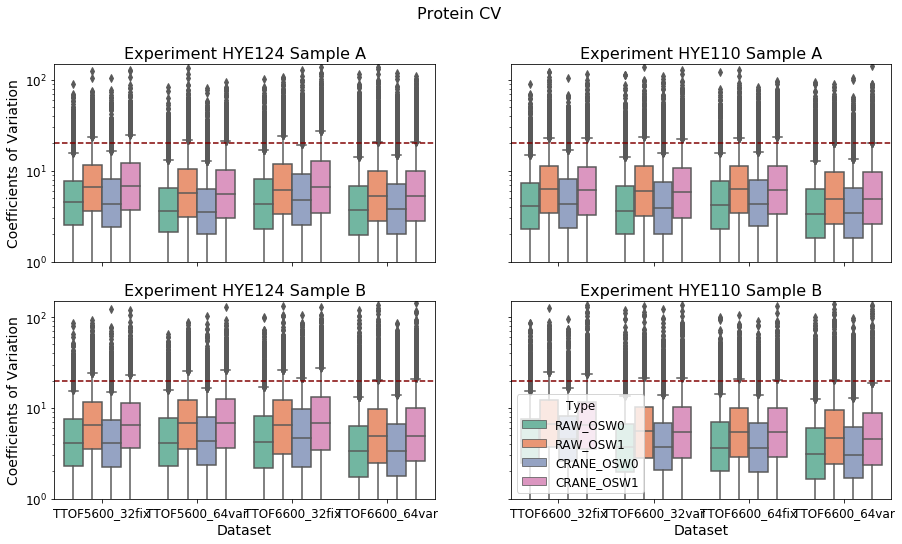

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
sns.boxplot(
    data=all_protein_cv.loc[(all_protein_cv.Experiment == 'hye124') & (all_protein_cv.Sample == 'A')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0,0],
)
axs[0,0].set_title('Experiment HYE124 Sample A')
axs[0,0].set_xlabel('Dataset')
axs[0,0].set_ylabel('Coefficients of Variation')
axs[0,0].set_yscale('log')
axs[0,0].axhline(20, ls='--', c='maroon', label='20 %')
axs[0,0].set_ylim((1, 150))
axs[0,0].get_legend().remove()

sns.boxplot(
    data=all_protein_cv.loc[(all_protein_cv.Experiment == 'hye124') & (all_protein_cv.Sample == 'B')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1,0],
)
axs[1,0].set_title('Experiment HYE124 Sample B')
axs[1,0].set_xlabel('Dataset')
axs[1,0].set_ylabel('Coefficients of Variation')
axs[1,0].set_yscale('log')
axs[1,0].axhline(20, ls='--', c='maroon', label='20 %')
axs[1,0].set_ylim((1, 150))
axs[1,0].get_legend().remove()

sns.boxplot(
    data=all_protein_cv.loc[(all_protein_cv.Experiment == 'hye110') & (all_protein_cv.Sample == 'A')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0,1],
)
axs[0,1].set_title('Experiment HYE110 Sample A')
axs[0,1].set_xlabel('Dataset')
axs[0,1].set_ylabel('Coefficients of Variation')
axs[0,1].set_yscale('log')
axs[0,1].axhline(20, ls='--', c='maroon', label='20 %')
axs[0,1].set_ylim((1, 150))
axs[0,1].get_legend().remove()

sns.boxplot(
    data=all_protein_cv.loc[(all_protein_cv.Experiment == 'hye110') & (all_protein_cv.Sample == 'B')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1,1],
)
axs[1,1].set_title('Experiment HYE110 Sample B')
axs[1,1].set_xlabel('Dataset')
axs[1,1].set_ylabel('Coefficients of Variation')
axs[1,1].set_yscale('log')
axs[1,1].axhline(20, ls='--', c='maroon', label='20 %')
axs[1,1].set_ylim((1, 150))

for ax in axs.flat:
    ax.label_outer()
plt.suptitle('Protein CV')
# plt.savefig('figures/Protein_CV_sample_A_and_B_seperate.pdf', dpi=300, format='pdf', bbox_inches='tight')

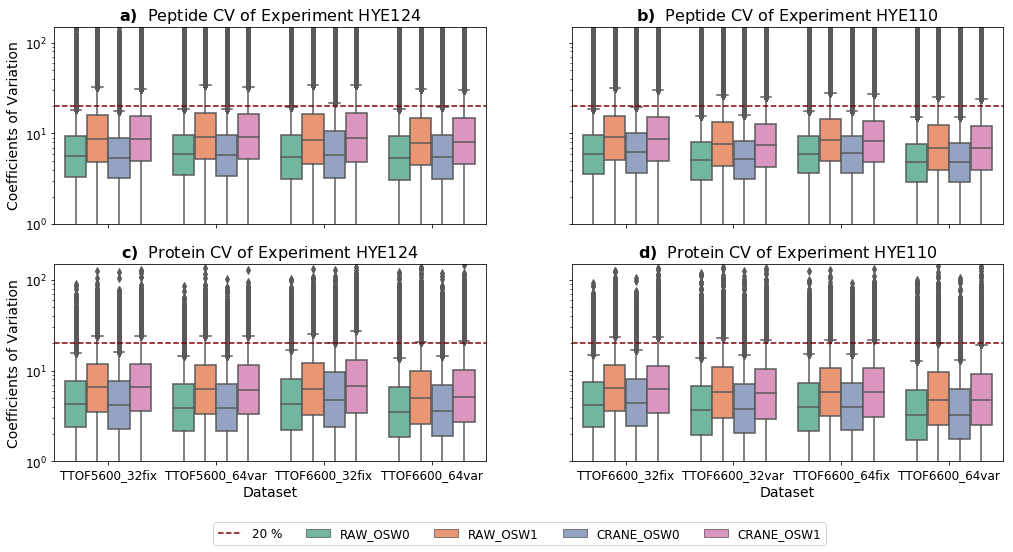

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(17, 8))
sns.boxplot(
    data=all_peptide_cv2.loc[(all_peptide_cv2.Experiment == 'hye124')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0,0],
)
axs[0,0].set_title( r"$\bf{a)}$" + '  Peptide CV of Experiment HYE124')
axs[0,0].set_xlabel('Dataset')
axs[0,0].set_ylabel('Coefficients of Variation')
axs[0,0].set_yscale('log')
axs[0,0].axhline(20, ls='--', c='maroon', label='20 %')
axs[0,0].set_ylim((1, 150))
axs[0,0].get_legend().remove()

sns.boxplot(
    data=all_protein_cv.loc[(all_protein_cv.Experiment == 'hye124')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1,0],
)
axs[1,0].set_title(r"$\bf{c)}$" + '  Protein CV of Experiment HYE124')
axs[1,0].set_xlabel('Dataset')
axs[1,0].set_ylabel('Coefficients of Variation')
axs[1,0].set_yscale('log')
axs[1,0].axhline(20, ls='--', c='maroon', label='20 %')
axs[1,0].set_ylim((1, 150))
axs[1,0].get_legend().remove()

sns.boxplot(
    data=all_peptide_cv2.loc[(all_peptide_cv2.Experiment == 'hye110')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0,1],
)
axs[0,1].set_title(r"$\bf{b)}$" + '  Peptide CV of Experiment HYE110')
axs[0,1].set_xlabel('Dataset')
axs[0,1].set_ylabel('Coefficients of Variation')
axs[0,1].set_yscale('log')
axs[0,1].axhline(20, ls='--', c='maroon', label='20 %')
axs[0,1].set_ylim((1, 150))
axs[0,1].get_legend().remove()

sns.boxplot(
    data=all_protein_cv.loc[(all_protein_cv.Experiment == 'hye110')],
    x='Group_by',
    y='CV',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1,1],
)
axs[1,1].set_title(r"$\bf{d)}$" + '  Protein CV of Experiment HYE110')
axs[1,1].set_xlabel('Dataset')
axs[1,1].set_ylabel('Coefficients of Variation')
axs[1,1].set_yscale('log')
axs[1,1].axhline(20, ls='--', c='maroon', label='20 %')
axs[1,1].set_ylim((1, 150))

for ax in axs.flat:
    ax.label_outer()

axs[1,1].legend(bbox_to_anchor=(0.25,0.03), loc="upper left",  bbox_transform=fig.transFigure, ncol = 5)
plt.savefig('figures/Peptide_n_protein_CV.eps', dpi=350, format='eps', bbox_inches='tight')

### Store protein CV stats

In [42]:
protein_cv_median = all_protein_cv.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species'])['CV'].median().to_frame()
protein_cv_median.reset_index(inplace=True)
protein_cv_median = protein_cv_median.rename(columns={'CV': 'Protein_CV_Median'})
protein_cv_variance = all_protein_cv.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species'])['CV'].std().to_frame()
protein_cv_variance.reset_index(inplace=True)
protein_cv_variance = protein_cv_variance.rename(columns={'CV': 'Protein_CV_STD'})
protein_stats = protein_cv_variance.merge(protein_cv_median, how = 'inner')
protein_stats.head()

,Type,Experiment,Machine,WindowSetup,Species,Protein_CV_STD,Protein_CV_Median
0,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,9.102328,5.061259
1,CRANE_OSW0,hye110,TTOF6600,32fix,HUMAN,5.991561,4.089026
2,CRANE_OSW0,hye110,TTOF6600,32fix,YEAST,9.998530,4.966003
3,CRANE_OSW0,hye110,TTOF6600,32var,ECOLI,9.811552,4.478110
4,CRANE_OSW0,hye110,TTOF6600,32var,HUMAN,5.575417,3.262639


## Compare number of protein IDs

In [43]:
protein_count = all_protein_data.groupby(['Type', 'sample_key', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Replication'])[['Intensity (log2)']].count().reset_index()
protein_count.rename(columns={'Intensity (log2)': 'protein_count'}, inplace=True)
protein_count['Group_by'] = protein_count['Machine'] + '_' + protein_count['WindowSetup']

In [44]:
species_protein_count = all_protein_data.groupby(['sample_key', 'Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'Replication'])[['Intensity (log2)']].count().reset_index()
species_protein_count.rename(columns={'Intensity (log2)': 'protein_count'}, inplace=True)
median_species_protein_count = species_protein_count.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species'])[['protein_count']].median().reset_index()
median_species_protein_count.rename(columns={'protein_count': 'Median_Protein_Count'}, inplace=True)


In [45]:
Protein_Detection_Improvement = pd.DataFrame(columns=['sample_key', 'Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'Replication', 'Protein_Detection_Improvement'])
sample_key_list = species_protein_count.sample_key.unique().tolist()
for sample_key in sample_key_list:
    temp = species_protein_count.loc[species_protein_count.sample_key == sample_key]
    species_list = temp.Species.unique().tolist()
    for species in species_list:
        temp2 = temp.loc[temp.Species == species]
        ref_protein_count = temp2.loc[temp2.Type ==Reference]['protein_count'].values.tolist()[0]
        type_list = temp2.Type.unique().tolist()
        for typ in type_list:
            if typ != Reference:
                temp3 = temp2.loc[temp2.Type == typ]
                protein_count = temp3['protein_count'].values.tolist()[0]
                protein_improvement = (protein_count - ref_protein_count)/ref_protein_count * 100
                Protein_Detection_Improvement = Protein_Detection_Improvement.append(
                    {
                        'sample_key':sample_key,
                        'Type': typ,
                        'Experiment':temp3.Experiment.tolist()[0],
                        'Machine':temp3.Machine.tolist()[0],
                        'WindowSetup':temp3.WindowSetup.tolist()[0],
                        'Sample': temp3.Sample.tolist()[0],
                        'Species': species,
                        'Replication':temp3.Replication.tolist()[0],
                        'Protein_Detection_Improvement':protein_improvement
                    },
                    ignore_index=True
                )
Protein_Detection_Improvement['Group_by'] = Protein_Detection_Improvement['Machine'] + '_' +Protein_Detection_Improvement['WindowSetup']

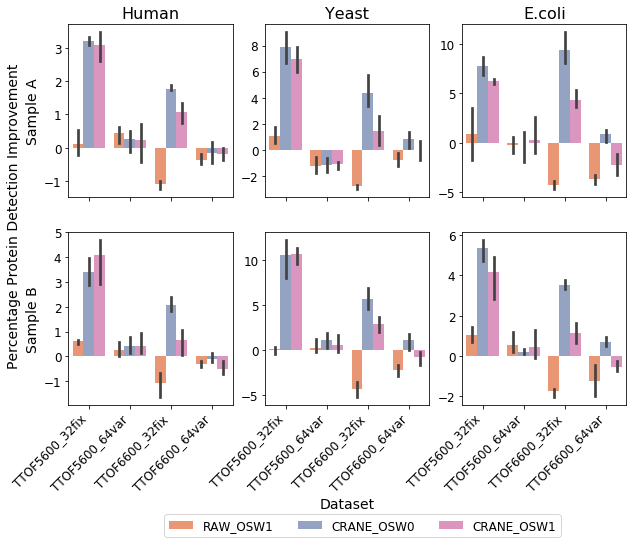

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex='col')

species_list = ['HUMAN', 'YEAST', 'ECOLI']
species_list2 = ['Human', 'Yeast', 'E.coli']
for i in range(len(species_list)):
    temp = Protein_Detection_Improvement.loc[(Protein_Detection_Improvement.Experiment == 'hye124') & (Protein_Detection_Improvement.Species == species_list[i])]

    sns.barplot(
        data=temp.loc[(temp.Sample == 'A')],
        x='Group_by',
        y='Protein_Detection_Improvement',
        hue='Type',
        hue_order=hue_order_less_ref,
        palette=palette_less_ref,
        ax=axs[0,i],
    )
    axs[0,i].set_title('{}'.format(species_list2[i]))
    axs[0,i].set_xlabel('')
    if i == 0:
        axs[0,i].set_ylabel('Sample A')
    else:
        axs[0,i].set_ylabel('')
    axs[0,i].get_legend().remove()
    axs[0,i].tick_params('x', labelrotation=45) 


    sns.barplot(
        data=temp.loc[(temp.Sample == 'B')],
        x='Group_by',
        y='Protein_Detection_Improvement',
        hue='Type',
        hue_order=hue_order_less_ref,
        palette=palette_less_ref,
        ax=axs[1,i],
    )
    if i == 1:
        axs[1,i].set_xlabel('Dataset')
    else:
        axs[1,i].set_xlabel('')
    if i == 0:
        axs[1,i].set_ylabel('Sample B')
    else:
        axs[1,i].set_ylabel('')
    axs[1,i].get_legend().remove()
    axs[1,i].tick_params('x', labelrotation=45) 
    for tick in axs[1,i].xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")
    
axs[1,0].legend(bbox_to_anchor=(0.25,-0.08), loc="upper left",  bbox_transform=fig.transFigure, ncol = 4)
fig.text(0.04, 0.5, 'Percentage Protein Detection Improvement', va='center', rotation='vertical', fontsize =14)
# plt.suptitle('Protein Detection of Experiment HYE124')
plt.savefig('figures/Experiment_124_protein_ID_stats_per_species.eps', dpi=350, format='eps', bbox_inches='tight')

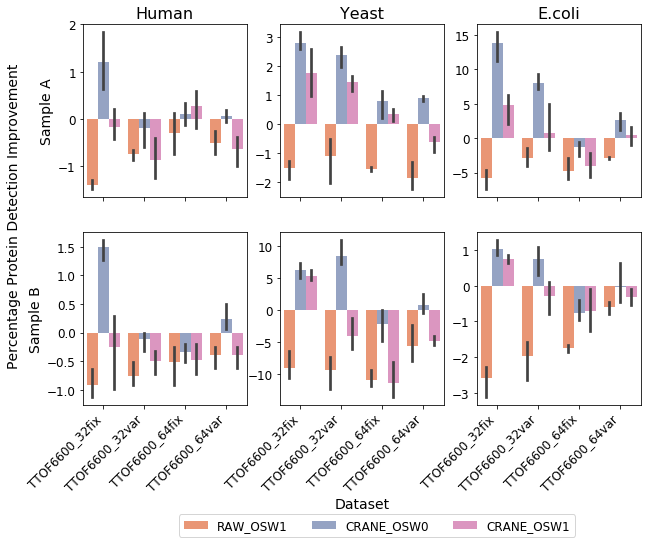

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex='col')

species_list = ['HUMAN', 'YEAST', 'ECOLI']
species_list2 = ['Human', 'Yeast', 'E.coli']
for i in range(len(species_list)):
    temp = Protein_Detection_Improvement.loc[(Protein_Detection_Improvement.Experiment == 'hye110') & (Protein_Detection_Improvement.Species == species_list[i])]

    sns.barplot(
        data=temp.loc[(temp.Sample == 'A')],
        x='Group_by',
        y='Protein_Detection_Improvement',
        hue='Type',
        hue_order=hue_order_less_ref,
        palette=palette_less_ref,
        ax=axs[0,i],
    )
    axs[0,i].set_title('{}'.format(species_list2[i]))
    axs[0,i].set_xlabel('')
    if i == 0:
        axs[0,i].set_ylabel('Sample A')
    else:
        axs[0,i].set_ylabel('')
    axs[0,i].get_legend().remove()
    axs[0,i].tick_params('x', labelrotation=45) 


    sns.barplot(
        data=temp.loc[(temp.Sample == 'B')],
        x='Group_by',
        y='Protein_Detection_Improvement',
        hue='Type',
        hue_order=hue_order_less_ref,
        palette=palette_less_ref,
        ax=axs[1,i],
    )
    if i == 1:
        axs[1,i].set_xlabel('Dataset')
    else:
        axs[1,i].set_xlabel('')
    if i == 0:
        axs[1,i].set_ylabel('Sample B')
    else:
        axs[1,i].set_ylabel('')
    axs[1,i].get_legend().remove()
    axs[1,i].tick_params('x', labelrotation=45) 
    for tick in axs[1,i].xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")
    
axs[1,0].legend(bbox_to_anchor=(0.25,-0.08), loc="upper left",  bbox_transform=fig.transFigure, ncol = 4)
fig.text(0.02, 0.5, 'Percentage Protein Detection Improvement', va='center', rotation='vertical', fontsize =14)
# plt.suptitle('Protein Detection of Experiment HYE110')
plt.savefig('figures/Experiment_110_protein_ID_stats_per_species.eps', dpi=350, format='eps', bbox_inches='tight')

### Store protein count stats

In [48]:
protein_stats = protein_stats.merge(median_species_protein_count, how = 'inner')
Median_Protein_Detection_Improvement = Protein_Detection_Improvement.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species'])[['Protein_Detection_Improvement']].median().reset_index()
Median_Protein_Detection_Improvement.rename(columns={'Protein_Detection_Improvement': 'Median_Protein_Detection_Improvement'}, inplace=True)
protein_stats = protein_stats.merge(Median_Protein_Detection_Improvement, how = 'left')
protein_stats.head()

,Type,Experiment,Machine,WindowSetup,Species,Protein_CV_STD,Protein_CV_Median,Sample,Median_Protein_Count,Median_Protein_Detection_Improvement
0,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,9.102328,5.061259,A,328,14.930556
1,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,9.102328,5.061259,B,940,0.980392
2,CRANE_OSW0,hye110,TTOF6600,32fix,HUMAN,5.991561,4.089026,A,1443,1.121233
3,CRANE_OSW0,hye110,TTOF6600,32fix,HUMAN,5.991561,4.089026,B,1446,1.609517
4,CRANE_OSW0,hye110,TTOF6600,32fix,YEAST,9.998530,4.966003,A,875,2.612827


## Protain abundance ratio

In [49]:
averaged_protein_data = all_protein_data.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species', 'Sample', 'Protein'])['Intensity (log2)'].mean().reset_index()
averaged_protein_data['Abundance Ratios (log2)'] = np.nan
columns = list (averaged_protein_data.columns.values)
columns.append('Intensity B (log2)')
columns = np.asarray(columns)
abundance_protein_ratios = pd.DataFrame(columns=columns)
experiemnt_list = averaged_protein_data.Experiment.unique().tolist()
for experiemnt in experiemnt_list:
    temp = averaged_protein_data.loc[averaged_protein_data.Experiment == experiemnt]
    machine_list = temp.Machine.unique().tolist()
    for machine in machine_list:
        temp2 = temp.loc[temp.Machine == machine]
        window_list = temp2.WindowSetup.unique().tolist() 
        for window in window_list:
            temp3 = temp2.loc[temp2.WindowSetup == window]
            type_list = temp3.Type.unique().tolist()
            for typ in type_list:
                a_sample = temp3.loc[
                    (temp3.Type == typ) &
                    (temp3.Sample == 'A')
                ]
                b_sample = temp3.loc[
                    (temp3.Type == typ) &
                    (temp3.Sample == 'B')
                ]
                a_sample = a_sample.dropna(subset=['Intensity (log2)'])
                b_sample = b_sample.dropna(subset=['Intensity (log2)'])
                b_sample = b_sample[['Protein', 'Intensity (log2)']]
                b_sample = b_sample.rename(columns={'Intensity (log2)': 'Intensity B (log2)'})
                a_sample = a_sample.merge(b_sample, how='inner')
                a_sample['Abundance Ratios (log2)'] = a_sample['Intensity (log2)'] - a_sample['Intensity B (log2)']
                a_sample = a_sample[columns]
                abundance_protein_ratios = abundance_protein_ratios.append(a_sample, ignore_index=True)
abundance_protein_ratios = abundance_protein_ratios.rename(columns={'Intensity (log2)': 'Intensity A (log2)'})
abundance_protein_ratios.drop(columns=['Sample'], inplace=True)
abundance_protein_ratios['Group_by'] = abundance_protein_ratios['Machine'] + '_' + abundance_protein_ratios['WindowSetup']

In [50]:
abundance_protein_ratios.head()

,Type,Experiment,Machine,WindowSetup,Species,Protein,Intensity A (log2),Abundance Ratios (log2),Intensity B (log2),Group_by
0,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,1/sp|P00350|6PGD_ECOLI,-2.709426,-2.926703,0.217277,TTOF6600_32fix
1,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,1/sp|P00363|FRDA_ECOLI,-2.550154,-2.948632,0.398478,TTOF6600_32fix
2,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,1/sp|P00509|AAT_ECOLI,-1.953482,-2.223616,0.270134,TTOF6600_32fix
3,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,1/sp|P00561|AK1H_ECOLI,-2.445399,-2.276701,-0.168698,TTOF6600_32fix
4,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,1/sp|P00579|RPOD_ECOLI,-2.774254,-2.926957,0.152703,TTOF6600_32fix


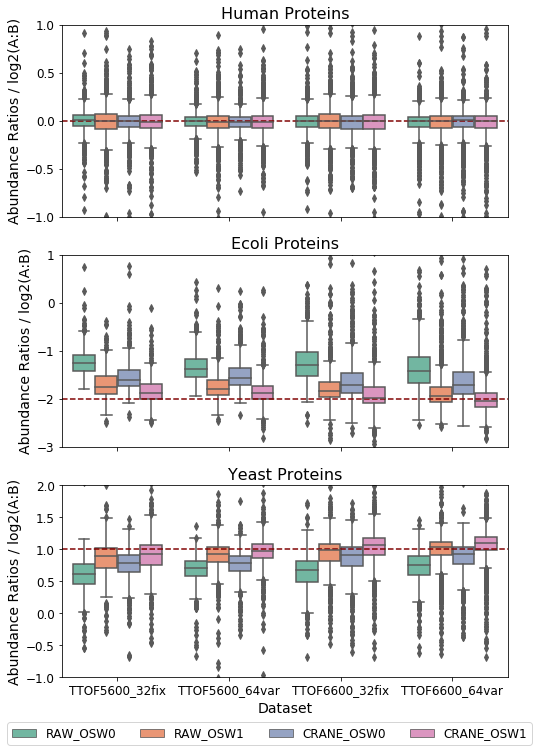

In [51]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
 
sns.boxplot(
    data=abundance_protein_ratios.loc[(abundance_protein_ratios.Experiment == 'hye124') & (abundance_protein_ratios.Species == 'HUMAN')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0],
)
axs[0].set_title('Human Proteins')
axs[0].plot([-0.5, 3.5], [np.log2(1)] * 2, ls='--', c='maroon')
axs[0].get_legend().remove()
axs[0].set_ylim((-1, 1))
axs[0].set_ylabel('Abundance Ratios / log2(A:B)')
axs[0].set_xlabel('Dataset')

sns.boxplot(
    data=abundance_protein_ratios.loc[(abundance_protein_ratios.Experiment == 'hye124') & (abundance_protein_ratios.Species == 'ECOLI')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1],
)
axs[1].set_title('Ecoli Proteins')
axs[1].plot([-0.5, 3.5], [np.log2(1/4)] * 2, ls='--', c='maroon')
axs[1].get_legend().remove()
axs[1].set_ylim((-3, 1))
axs[1].set_ylabel('Abundance Ratios / log2(A:B)')
axs[1].set_xlabel('Dataset')

sns.boxplot(
    data=abundance_protein_ratios.loc[(abundance_protein_ratios.Experiment == 'hye124') & (abundance_protein_ratios.Species == 'YEAST')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[2],
)
axs[2].set_title('Yeast Proteins')
axs[2].plot([-0.5, 3.5], [np.log2(2)] * 2, ls='--', c='maroon')
axs[2].legend(bbox_to_anchor=(0.02, 0.08), loc="upper left",  bbox_transform=fig.transFigure, ncol = 4)
axs[2].set_ylim((-1, 2))
axs[2].set_ylabel('Abundance Ratios / log2(A:B)')
axs[2].set_xlabel('Dataset')
for ax in axs.flat:
    ax.label_outer()

# plt.suptitle('Protein Abundance Ratio of Experiment HYE124', y=0.95)
plt.savefig('figures/Experiment_124_protein_abundance_ratio_box_plots.eps', dpi=350, format='eps', bbox_inches='tight')

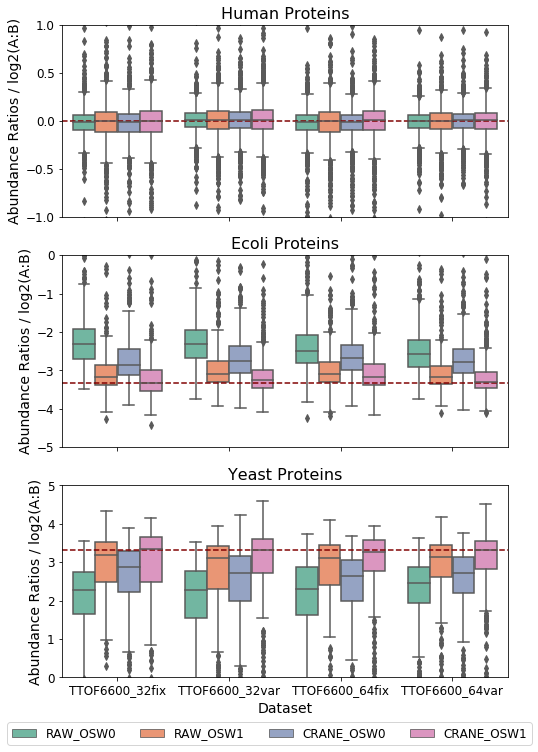

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
 
sns.boxplot(
    data=abundance_protein_ratios.loc[(abundance_protein_ratios.Experiment == 'hye110') & (abundance_protein_ratios.Species == 'HUMAN')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[0],
)
axs[0].set_title('Human Proteins')
axs[0].plot([-0.5, 3.5], [np.log2(1)] * 2, ls='--', c='maroon')
axs[0].get_legend().remove()
axs[0].set_ylim((-1, 1))
axs[0].set_ylabel('Abundance Ratios / log2(A:B)')
axs[0].set_xlabel('Dataset')

sns.boxplot(
    data=abundance_protein_ratios.loc[(abundance_protein_ratios.Experiment == 'hye110') & (abundance_protein_ratios.Species == 'ECOLI')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[1],
)
axs[1].set_title('Ecoli Proteins')
axs[1].plot([-0.5, 3.5], [np.log2(3/30)] * 2, ls='--', c='maroon')
axs[1].get_legend().remove()
axs[1].set_ylim((-5, 0))
axs[1].set_ylabel('Abundance Ratios / log2(A:B)')
axs[1].set_xlabel('Dataset')

sns.boxplot(
    data=abundance_protein_ratios.loc[(abundance_protein_ratios.Experiment == 'hye110') & (abundance_protein_ratios.Species == 'YEAST')],
    x='Group_by',
    y='Abundance Ratios (log2)',
    hue='Type',
    hue_order=hue_order,
    palette=palette,
    ax=axs[2],
)
axs[2].set_title('Yeast Proteins')
axs[2].plot([-0.5, 3.5], [np.log2(30/3)] * 2, ls='--', c='maroon')
axs[2].legend(bbox_to_anchor=(0.02, 0.08), loc="upper left",  bbox_transform=fig.transFigure, ncol = 4)
axs[2].set_ylim((0, 5))
axs[2].set_ylabel('Abundance Ratios / log2(A:B)')
axs[2].set_xlabel('Dataset')
for ax in axs.flat:
    ax.label_outer()

# plt.suptitle('Protein Abundance Ratio of Experiment HYE110', y=0.95)
plt.savefig('figures/Experiment_110_protein_abundance_ratio_box_plots.eps', dpi=350, format='eps', bbox_inches='tight')

### Calculate species seperation arctanh measure

In [53]:
protein_abundance_ratio_species_seperation = pd.DataFrame(columns=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Protein_Overlap_Yeast_Human_arctanh', 'Protein_Overlap_E_Coli_Human_arctanh'])
columns = abundance_protein_ratios.columns.values
filtered_abundance_protein_ratios = pd.DataFrame(columns=columns)
threshold_range = np.linspace(-5, 5, 201)
experiment_list = abundance_protein_ratios.Experiment.unique().tolist()
for experiment in experiment_list:
    temp = abundance_protein_ratios.loc[abundance_protein_ratios.Experiment == experiment]
    machine_list = temp.Machine.unique().tolist()
    for machine in machine_list:
        temp2 = temp.loc[temp.Machine == machine]
        windowsetup_list = temp2.WindowSetup.unique().tolist()
        for windowsetup in windowsetup_list:
            temp3 = temp2.loc[temp2.WindowSetup == windowsetup]
            type_list = temp3.Type.unique().tolist()
            # filter out proteins that are not detected by all the methods
            if filter_common_proteins == True:
                common_proteins = temp3.groupby(['Protein'])['Type'].count().reset_index()
                common_proteins = common_proteins.rename(columns={'Type': 'Type_Count'})
                common_proteins = common_proteins.loc[common_proteins.Type_Count == len(type_list)]
                temp3 = temp3.merge(common_proteins, how='inner', left_on=['Protein'], right_on=['Protein'])
            temp3 = temp3[columns]
            filtered_abundance_protein_ratios = filtered_abundance_protein_ratios.append(temp3, ignore_index=True)
            for typ in type_list:
                temp4 = temp3.loc[temp3.Type == typ]
                ## Overlap Yeast - Human
                ROC = pd.DataFrame(columns=['Threshold', 'TPR', 'FPR'])
                for threshold in threshold_range:
                    P = temp4.loc[
                            (temp4.Species == 'HUMAN')
                        ].shape[0]
                    TP = temp4.loc[
                            (temp4.Species == 'HUMAN') &
                            (temp4['Abundance Ratios (log2)']<threshold)
                        ].shape[0]
                    TPR = TP/P
                    N = temp4.loc[
                            (temp4.Species == 'YEAST')
                        ].shape[0]
                    FP = temp4.loc[
                            (temp4.Species == 'YEAST') &
                            (temp4['Abundance Ratios (log2)']<threshold)
                        ].shape[0]
                    FPR = FP/N
                    ROC = ROC.append(
                        {
                            'Threshold': threshold,
                            'TPR' : TPR,
                            'FPR' : FPR
                        },
                        ignore_index=True
                    )
                AUC = 0
                for i in range(1, ROC.shape[0], 1):
                    AUC = AUC + ROC.iloc[i,1] * abs(ROC.iloc[i,2] - ROC.iloc[i-1,2])
                Protein_Overlap_Yeast_Human_arctanh = np.arctanh(AUC)

                ## Overlap E. coli - Human
                ROC = pd.DataFrame(columns=['Threshold', 'TPR', 'FPR'])
                for threshold in threshold_range:
                    P = temp4.loc[
                            (temp4.Species == 'HUMAN')
                        ].shape[0]
                    TP = temp4.loc[
                            (temp4.Species == 'HUMAN') &
                            (temp4['Abundance Ratios (log2)']>threshold)
                        ].shape[0]
                    TPR = TP/P
                    N = temp4.loc[
                            (temp4.Species == 'ECOLI')
                        ].shape[0]
                    FP = temp4.loc[
                            (temp4.Species == 'ECOLI') &
                            (temp4['Abundance Ratios (log2)']>threshold)
                        ].shape[0]
                    FPR = FP/N
                    ROC = ROC.append(
                        {
                            'Threshold': threshold,
                            'TPR' : TPR,
                            'FPR' : FPR
                        },
                        ignore_index=True
                    )
                AUC = 0
                for i in range(1, ROC.shape[0], 1):
                    AUC = AUC + ROC.iloc[i,1] * abs(ROC.iloc[i,2] - ROC.iloc[i-1,2])
                Protein_Overlap_E_Coli_Human_arctanh = np.arctanh(AUC)
                protein_abundance_ratio_species_seperation = protein_abundance_ratio_species_seperation.append(
                    {
                        'Type': typ,
                        'Experiment': experiment,
                        'Machine': machine,
                        'WindowSetup': windowsetup,
                        'Protein_Overlap_Yeast_Human_arctanh' : Protein_Overlap_Yeast_Human_arctanh,
                        'Protein_Overlap_E_Coli_Human_arctanh' : Protein_Overlap_E_Coli_Human_arctanh
                    },
                    ignore_index=True
                )

### Store protein abundance ratio

In [54]:
# Median deviation from expected abundance ratio
protein_abundance_ratio_median = filtered_abundance_protein_ratios.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species'])[['Abundance Ratios (log2)']].median().reset_index()
protein_abundance_ratio_median.rename(columns={'Abundance Ratios (log2)': 'Median_Abundance_Ratios'}, inplace=True)
protein_abundance_ratio_median.loc[(protein_abundance_ratio_median.Species == 'HUMAN'), 'Expected_Abundance_Ratio'] = 0
protein_abundance_ratio_median.loc[(protein_abundance_ratio_median.Experiment == 'hye124') & (protein_abundance_ratio_median.Species == 'ECOLI'), 'Expected_Abundance_Ratio'] = np.log2(1/4)
protein_abundance_ratio_median.loc[(protein_abundance_ratio_median.Experiment == 'hye124') & (protein_abundance_ratio_median.Species == 'YEAST'), 'Expected_Abundance_Ratio'] = np.log2(2)
protein_abundance_ratio_median.loc[(protein_abundance_ratio_median.Experiment == 'hye110') & (protein_abundance_ratio_median.Species == 'ECOLI'), 'Expected_Abundance_Ratio'] = np.log2(3/30)
protein_abundance_ratio_median.loc[(protein_abundance_ratio_median.Experiment == 'hye110') & (protein_abundance_ratio_median.Species == 'YEAST'), 'Expected_Abundance_Ratio'] = np.log2(30/3)
protein_abundance_ratio_median['Protein_Abundance_Ratios_Median_Deviation'] = protein_abundance_ratio_median['Median_Abundance_Ratios'] - protein_abundance_ratio_median['Expected_Abundance_Ratio']
protein_abundance_ratio_median['Protein_Abundance_Ratios_Median_Deviation'] = protein_abundance_ratio_median['Protein_Abundance_Ratios_Median_Deviation'].abs()

# Standard deviation of the abundance ratios
protein_abundance_ratio_std = filtered_abundance_protein_ratios.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species'])[['Abundance Ratios (log2)']].std().reset_index()
protein_abundance_ratio_std.rename(columns={'Abundance Ratios (log2)': 'Protein_Abundance_Ratios_STD'}, inplace=True)

# Mean of the abundance ratios
protein_abundance_ratio_avg = filtered_abundance_protein_ratios.groupby(['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species'])[['Abundance Ratios (log2)']].mean().reset_index()
protein_abundance_ratio_avg.rename(columns={'Abundance Ratios (log2)': 'Protein_Abundance_Ratios_Avg'}, inplace=True)
protein_abundance_ratio_avg['Protein_Abundance_Ratios_Mean_T_Test_Relative_to_Expected_P_Value'] = np.nan

# median deviation from expected abundance ratios on protein level for each tertile and protein count within validity range (+/- n*s.d.)
protein_abundance_ratio_tertile_median = pd.DataFrame(columns=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species', '1st_Tertile_Median_Abundance_Ratios', '2nd_Tertile_Median_Abundance_Ratios', '3rd_Tertile_Median_Abundance_Ratios'])
protein_count_within_validity_range = pd.DataFrame(columns=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species', 'protein_count_within_3sd_validity_range', 'protein_count_within_5sd_validity_range'])
protein_count_improvement_within_validity_range = pd.DataFrame(columns=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species', 'protein_count_improvement_within_3sd_validity_range', 'protein_count_improvement_within_5sd_validity_range'])
protein_statistical_variance_test_relative_to_ref = pd.DataFrame(columns=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Species', 'Protein_Abundance_Ratios_Variance_Levene_Stat_Relative_to_Ref', 'Protein_Abundance_Ratios_Variance_Levene_Relative_to_Ref_P_Value'])

experiment_list = filtered_abundance_protein_ratios.Experiment.unique().tolist()
for experiment in experiment_list:
    temp = filtered_abundance_protein_ratios.loc[filtered_abundance_protein_ratios.Experiment == experiment]
    machine_list = temp.Machine.unique().tolist()
    for machine in machine_list:
        temp2 = temp.loc[temp.Machine == machine]
        windowsetup_list = temp2.WindowSetup.unique().tolist()
        for windowsetup in windowsetup_list:
            temp3 = temp2.loc[temp2.WindowSetup == windowsetup]
            species_list = temp3.Species.unique().tolist()
            for species in species_list:
                temp4 = temp3.loc[temp3.Species == species]
                type_list = temp4.Type.unique().tolist()
                for typ in type_list:
                    temp5 = temp4.loc[temp4.Type == typ]
                    # Test whether mean abundance ratio is equal to the expected
                    expected_abundance_ratio = protein_abundance_ratio_median.loc[
                        (protein_abundance_ratio_median.Experiment == experiment) &
                        (protein_abundance_ratio_median.Species == species)
                    ]['Expected_Abundance_Ratio'].tolist()[0]
                    stat, pval = ttest_1samp(temp5['Abundance Ratios (log2)'].tolist(), expected_abundance_ratio)
                    protein_abundance_ratio_avg.at[
                        (protein_abundance_ratio_avg.Type == typ) &
                        (protein_abundance_ratio_avg.Experiment == experiment) &
                        (protein_abundance_ratio_avg.Machine == machine) &
                        (protein_abundance_ratio_avg.WindowSetup == windowsetup) &
                        (protein_abundance_ratio_avg.Species == species)
                    ,'Protein_Abundance_Ratios_Mean_T_Test_Relative_to_Expected_P_Value'] = pval
                    
                    # Test wheather aundance ratio variance is equal to that of the reference.
                    if typ != Reference:
                        a = temp4.loc[temp4.Type == Reference]['Abundance Ratios (log2)'].tolist()
                        b = temp5['Abundance Ratios (log2)'].tolist()
                        stat, p = levene(a, b)
                        protein_statistical_variance_test_relative_to_ref = protein_statistical_variance_test_relative_to_ref.append(
                            {
                                'Type':typ,
                                'Experiment': experiment,
                                'Machine':machine,
                                'WindowSetup':windowsetup,
                                'Species': species,
                                'Protein_Abundance_Ratios_Variance_Levene_Stat_Relative_to_Ref' : stat,
                                'Protein_Abundance_Ratios_Variance_Levene_Relative_to_Ref_P_Value' : p
                            },
                            ignore_index=True
                        )
                    # median deviation from expected abundance ratios on protein level for each tertile
                    # 1st tertile: lowest intensity (0%-33.3%,)
                    Median_Abundance_Ratio1 = temp5.loc[temp5['Intensity B (log2)'] < np.percentile(temp5['Intensity B (log2)'], 33.3), 'Abundance Ratios (log2)'].median()
                    # 2nd tertile: medium intensity (33.3%-66.7%)
                    Median_Abundance_Ratio2 = temp5.loc[(temp5['Intensity B (log2)'] >= np.percentile(temp5['Intensity B (log2)'], 33.3)) & (temp5['Intensity B (log2)'] < np.percentile(temp5['Intensity B (log2)'], 66.7)), 'Abundance Ratios (log2)'].median()
                    # 3rd: highest intensity (66.7%-100%)
                    Median_Abundance_Ratio3 = temp5.loc[temp5['Intensity B (log2)'] >= np.percentile(temp5['Intensity B (log2)'], 66.7), 'Abundance Ratios (log2)'].median()
                    protein_abundance_ratio_tertile_median = protein_abundance_ratio_tertile_median.append(
                        {
                            'Type':typ,
                            'Experiment': experiment,
                            'Machine':machine,
                            'WindowSetup':windowsetup,
                            'Species': species,
                            '1st_Tertile_Median_Abundance_Ratios':Median_Abundance_Ratio1,
                            '2nd_Tertile_Median_Abundance_Ratios':Median_Abundance_Ratio2,
                            '3rd_Tertile_Median_Abundance_Ratios':Median_Abundance_Ratio3,
                        },
                        ignore_index=True
                    )
experiment_list = abundance_protein_ratios.Experiment.unique().tolist()
for experiment in experiment_list:
    temp = abundance_protein_ratios.loc[abundance_protein_ratios.Experiment == experiment]
    machine_list = temp.Machine.unique().tolist()
    for machine in machine_list:
        temp2 = temp.loc[temp.Machine == machine]
        windowsetup_list = temp2.WindowSetup.unique().tolist()
        for windowsetup in windowsetup_list:
            temp3 = temp2.loc[temp2.WindowSetup == windowsetup]
            species_list = temp3.Species.unique().tolist()
            for species in species_list:
                temp4 = temp3.loc[temp3.Species == species]
                type_list = temp4.Type.unique().tolist()
                for typ in type_list:
                    temp5 = temp4.loc[temp4.Type == typ]
                    # protein count within validity range (+/-5s.d.)
                    mean = protein_abundance_ratio_avg.loc[
                        (protein_abundance_ratio_avg.Type == typ) & 
                        (protein_abundance_ratio_avg.Experiment == experiment) & 
                        (protein_abundance_ratio_avg.Machine == machine) &
                        (protein_abundance_ratio_avg.WindowSetup == windowsetup) &
                        (protein_abundance_ratio_avg.Species == species)
                    ]['Protein_Abundance_Ratios_Avg'].tolist()[0]
                    std = protein_abundance_ratio_std.loc[
                        (protein_abundance_ratio_std.Type == typ) & 
                        (protein_abundance_ratio_std.Experiment == experiment) & 
                        (protein_abundance_ratio_std.Machine == machine) &
                        (protein_abundance_ratio_std.WindowSetup == windowsetup) &
                        (protein_abundance_ratio_std.Species == species)
                    ]['Protein_Abundance_Ratios_STD'].tolist()[0]
                    temp6 = temp5.loc[(temp5['Abundance Ratios (log2)'] <= (mean + (5 * std))) & (temp5['Abundance Ratios (log2)'] >= (mean - (5 * std)))]
                    temp6 = temp6.dropna(subset=['Abundance Ratios (log2)'])
                    protein_count_within_5sd_validity_range = temp6.shape[0]
                    temp6 = temp5.loc[(temp5['Abundance Ratios (log2)'] <= (mean + (3 * std))) & (temp5['Abundance Ratios (log2)'] >= (mean - (3 * std)))]
                    temp6 = temp6.dropna(subset=['Abundance Ratios (log2)'])
                    protein_count_within_3sd_validity_range = temp6.shape[0]
                    protein_count_within_validity_range = protein_count_within_validity_range.append(
                        {
                            'Type':typ,
                            'Experiment': experiment,
                            'Machine':machine,
                            'WindowSetup':windowsetup,
                            'Species': species,
                            'protein_count_within_3sd_validity_range':protein_count_within_3sd_validity_range,
                            'protein_count_within_5sd_validity_range':protein_count_within_5sd_validity_range,
                        },
                        ignore_index=True
                    )
                ref_protein_count_3sd = protein_count_within_validity_range.loc[
                    (protein_count_within_validity_range.Type == Reference) &
                    (protein_count_within_validity_range.Experiment == experiment) &
                    (protein_count_within_validity_range.Machine == machine) &
                    (protein_count_within_validity_range.WindowSetup == windowsetup) &
                    (protein_count_within_validity_range.Species == species)
                ]['protein_count_within_3sd_validity_range'].values.tolist()[0]
                ref_protein_count_5sd = protein_count_within_validity_range.loc[
                    (protein_count_within_validity_range.Type == Reference) &
                    (protein_count_within_validity_range.Experiment == experiment) &
                    (protein_count_within_validity_range.Machine == machine) &
                    (protein_count_within_validity_range.WindowSetup == windowsetup) &
                    (protein_count_within_validity_range.Species == species)
                ]['protein_count_within_5sd_validity_range'].values.tolist()[0]
                for typ in type_list:
                    if typ != Reference:
                        protein_count_3sd = protein_count_within_validity_range.loc[
                            (protein_count_within_validity_range.Type == typ) &
                            (protein_count_within_validity_range.Experiment == experiment) &
                            (protein_count_within_validity_range.Machine == machine) &
                            (protein_count_within_validity_range.WindowSetup == windowsetup) &
                            (protein_count_within_validity_range.Species == species)
                        ]['protein_count_within_3sd_validity_range'].values.tolist()[0]
                        protein_count_5sd = protein_count_within_validity_range.loc[
                            (protein_count_within_validity_range.Type == typ) &
                            (protein_count_within_validity_range.Experiment == experiment) &
                            (protein_count_within_validity_range.Machine == machine) &
                            (protein_count_within_validity_range.WindowSetup == windowsetup) &
                            (protein_count_within_validity_range.Species == species)
                        ]['protein_count_within_5sd_validity_range'].values.tolist()[0]
                        protein_improvement_3sd = (protein_count_3sd - ref_protein_count_3sd)/ref_protein_count_3sd * 100
                        protein_improvement_5sd = (protein_count_5sd - ref_protein_count_5sd)/ref_protein_count_5sd * 100
                        protein_count_improvement_within_validity_range = protein_count_improvement_within_validity_range.append(
                            {
                                'Type':typ,
                                'Experiment': experiment,
                                'Machine':machine,
                                'WindowSetup':windowsetup,
                                'Species': species,
                                'protein_count_improvement_within_3sd_validity_range':protein_improvement_3sd,
                                'protein_count_improvement_within_5sd_validity_range':protein_improvement_5sd,
                            },
                            ignore_index=True
                        )
protein_abundance_ratio_median = protein_abundance_ratio_median.drop(columns=['Median_Abundance_Ratios', 'Expected_Abundance_Ratio'])
protein_abundance_ratio_tertile_median.loc[(protein_abundance_ratio_tertile_median.Species == 'HUMAN'), 'Expected_Abundance_Ratio'] = 0
protein_abundance_ratio_tertile_median.loc[(protein_abundance_ratio_tertile_median.Experiment == 'hye124') & (protein_abundance_ratio_tertile_median.Species == 'ECOLI'), 'Expected_Abundance_Ratio'] = np.log2(1/4)
protein_abundance_ratio_tertile_median.loc[(protein_abundance_ratio_tertile_median.Experiment == 'hye124') & (protein_abundance_ratio_tertile_median.Species == 'YEAST'), 'Expected_Abundance_Ratio'] = np.log2(2)
protein_abundance_ratio_tertile_median.loc[(protein_abundance_ratio_tertile_median.Experiment == 'hye110') & (protein_abundance_ratio_tertile_median.Species == 'ECOLI'), 'Expected_Abundance_Ratio'] = np.log2(3/30)
protein_abundance_ratio_tertile_median.loc[(protein_abundance_ratio_tertile_median.Experiment == 'hye110') & (protein_abundance_ratio_tertile_median.Species == 'YEAST'), 'Expected_Abundance_Ratio'] = np.log2(30/3)
protein_abundance_ratio_tertile_median['Protein_1st_Tertile_Abundance_Ratios_Median_Deviation'] = protein_abundance_ratio_tertile_median['1st_Tertile_Median_Abundance_Ratios'] - protein_abundance_ratio_tertile_median['Expected_Abundance_Ratio']
protein_abundance_ratio_tertile_median['Protein_1st_Tertile_Abundance_Ratios_Median_Deviation'] = protein_abundance_ratio_tertile_median['Protein_1st_Tertile_Abundance_Ratios_Median_Deviation'].abs()
protein_abundance_ratio_tertile_median['Protein_2nd_Tertile_Abundance_Ratios_Median_Deviation'] = protein_abundance_ratio_tertile_median['2nd_Tertile_Median_Abundance_Ratios'] - protein_abundance_ratio_tertile_median['Expected_Abundance_Ratio']
protein_abundance_ratio_tertile_median['Protein_2nd_Tertile_Abundance_Ratios_Median_Deviation'] = protein_abundance_ratio_tertile_median['Protein_2nd_Tertile_Abundance_Ratios_Median_Deviation'].abs()
protein_abundance_ratio_tertile_median['Protein_3rd_Tertile_Abundance_Ratios_Median_Deviation'] = protein_abundance_ratio_tertile_median['3rd_Tertile_Median_Abundance_Ratios'] - protein_abundance_ratio_tertile_median['Expected_Abundance_Ratio']
protein_abundance_ratio_tertile_median['Protein_3rd_Tertile_Abundance_Ratios_Median_Deviation'] = protein_abundance_ratio_tertile_median['Protein_3rd_Tertile_Abundance_Ratios_Median_Deviation'].abs()
protein_abundance_ratio_tertile_median = protein_abundance_ratio_tertile_median.drop(columns=['1st_Tertile_Median_Abundance_Ratios', '2nd_Tertile_Median_Abundance_Ratios', '3rd_Tertile_Median_Abundance_Ratios', 'Expected_Abundance_Ratio'])

#Store stats in protein_stats DF
protein_stats = protein_stats.merge(protein_abundance_ratio_median, how = 'inner')
protein_stats = protein_stats.merge(protein_abundance_ratio_avg, how = 'inner')
protein_stats = protein_stats.merge(protein_abundance_ratio_std, how = 'inner')
protein_stats = protein_stats.merge(protein_abundance_ratio_tertile_median, how = 'inner')
protein_stats = protein_stats.merge(protein_count_within_validity_range, how = 'inner')
protein_stats = protein_stats.merge(protein_count_improvement_within_validity_range, how = 'left')
protein_stats = protein_stats.merge(protein_statistical_variance_test_relative_to_ref, how = 'left')
protein_stats.head()

,Type,Experiment,Machine,WindowSetup,Species,Protein_CV_STD,Protein_CV_Median,Sample,Median_Protein_Count,Median_Protein_Detection_Improvement,...,Protein_Abundance_Ratios_STD,Protein_1st_Tertile_Abundance_Ratios_Median_Deviation,Protein_2nd_Tertile_Abundance_Ratios_Median_Deviation,Protein_3rd_Tertile_Abundance_Ratios_Median_Deviation,protein_count_within_3sd_validity_range,protein_count_within_5sd_validity_range,protein_count_improvement_within_3sd_validity_range,protein_count_improvement_within_5sd_validity_range,Protein_Abundance_Ratios_Variance_Levene_Stat_Relative_to_Ref,Protein_Abundance_Ratios_Variance_Levene_Relative_to_Ref_P_Value
0,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,9.102328,5.061259,A,328,14.930556,...,0.426515,0.681356,0.367169,0.063981,327,347,11.604096,12.662338,7.790770,0.005451
1,CRANE_OSW0,hye110,TTOF6600,32fix,ECOLI,9.102328,5.061259,B,940,0.980392,...,0.426515,0.681356,0.367169,0.063981,327,347,11.604096,12.662338,7.790770,0.005451
2,CRANE_OSW0,hye110,TTOF6600,32fix,HUMAN,5.991561,4.089026,A,1443,1.121233,...,0.194937,0.061607,0.002672,0.090343,1388,1401,0.945455,1.228324,17.374540,0.000032
3,CRANE_OSW0,hye110,TTOF6600,32fix,HUMAN,5.991561,4.089026,B,1446,1.609517,...,0.194937,0.061607,0.002672,0.090343,1388,1401,0.945455,1.228324,17.374540,0.000032
4,CRANE_OSW0,hye110,TTOF6600,32fix,YEAST,9.998530,4.966003,A,875,2.612827,...,0.657951,0.104440,0.177690,0.910606,190,208,3.260870,4.000000,1.718249,0.190970


In [55]:
stats = peptide_stats.merge(protein_stats, left_on=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species'], right_on=['Type', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species'], how='inner')
stats['Type_Sort'] = np.nan
stats.loc[stats.Type == 'RAW_OSW0', 'Type_Sort'] = 0
stats.loc[stats.Type == 'RAW_OSW1', 'Type_Sort'] = 1
stats.loc[stats.Type == 'CRANE_OSW0', 'Type_Sort'] = 2
stats.loc[stats.Type == 'CRANE_OSW1', 'Type_Sort'] = 3
stats.loc[stats.Experiment == 'hye110', 'Experiment'] = 'HYE110'
stats.loc[stats.Experiment == 'hye124', 'Experiment'] = 'HYE124'
stats = stats.sort_values(by=['Experiment', 'Machine', 'WindowSetup', 'Sample', 'Species', 'Type_Sort'])

In [56]:
species_seperation_stats = peptide_abundance_ratio_species_seperation.merge(
    protein_abundance_ratio_species_seperation,
    left_on=['Type', 'Experiment', 'Machine', 'WindowSetup'],
    right_on=['Type', 'Experiment', 'Machine', 'WindowSetup'],
    how='inner'
)
species_seperation_stats['Type_Sort'] = np.nan
species_seperation_stats.loc[species_seperation_stats.Type == 'RAW_OSW0', 'Type_Sort'] = 0
species_seperation_stats.loc[species_seperation_stats.Type == 'RAW_OSW1', 'Type_Sort'] = 1
species_seperation_stats.loc[species_seperation_stats.Type == 'CRANE_OSW0', 'Type_Sort'] = 2
species_seperation_stats.loc[species_seperation_stats.Type == 'CRANE_OSW1', 'Type_Sort'] = 3
species_seperation_stats.loc[species_seperation_stats.Experiment == 'hye110', 'Experiment'] = 'HYE110'
species_seperation_stats.loc[species_seperation_stats.Experiment == 'hye124', 'Experiment'] = 'HYE124'
species_seperation_stats = species_seperation_stats.sort_values(by=['Experiment', 'Machine', 'WindowSetup', 'Type_Sort'])

In [57]:
stats.loc[
    (stats.Sample == 'A') & (stats.Species == 'HUMAN'),
    ['Experiment', 'Machine', 'WindowSetup', 'Type', 'Peptide_CV_Median', 'Peptide_CV_STD', 'Protein_CV_Median', 'Protein_CV_STD']
].round(1).to_csv("peptide_n_protein_data/stats/Multicenter_HUMAN_CV_data.csv")

In [58]:
stats = stats.sort_values(by=['Sample', 'Experiment', 'Machine', 'WindowSetup', 'Species', 'Type_Sort'])

In [59]:
stats.loc[
    (stats.Experiment == 'HYE124') & (stats.Species == 'HUMAN'),
    ['Sample', 'Experiment', 'Machine', 'WindowSetup', 'Type', 'Median_Peptide_Count', 'Median_Peptide_Detection_Improvement', 'Median_Protein_Count', 'Median_Protein_Detection_Improvement']
].round({'Median_Peptide_Count': 0, 'Median_Peptide_Detection_Improvement': 1, 'Median_Protein_Count': 0, 'Median_Protein_Detection_Improvement': 1}).to_csv("peptide_n_protein_data/stats/Multicenter_HYE124_HUMAN_ID_data.csv")

In [60]:
stats.loc[
    (stats.Experiment == 'HYE124') & (stats.Species == 'YEAST'),
    ['Sample', 'Experiment', 'Machine', 'WindowSetup', 'Type', 'Median_Peptide_Count', 'Median_Peptide_Detection_Improvement', 'Median_Protein_Count', 'Median_Protein_Detection_Improvement']
].round({'Median_Peptide_Count': 0, 'Median_Peptide_Detection_Improvement': 1, 'Median_Protein_Count': 0, 'Median_Protein_Detection_Improvement': 1}).to_csv("peptide_n_protein_data/stats/Multicenter_HYE124_YEAST_ID_data.csv")

In [61]:
stats.loc[
    (stats.Experiment == 'HYE124') & (stats.Species == 'ECOLI'),
    ['Sample', 'Experiment', 'Machine', 'WindowSetup', 'Type', 'Median_Peptide_Count', 'Median_Peptide_Detection_Improvement', 'Median_Protein_Count', 'Median_Protein_Detection_Improvement']
].round({'Median_Peptide_Count': 0, 'Median_Peptide_Detection_Improvement': 1, 'Median_Protein_Count': 0, 'Median_Protein_Detection_Improvement': 1}).to_csv("peptide_n_protein_data/stats/Multicenter_HYE124_ECOLI_ID_data.csv")

In [62]:
stats.loc[
    (stats.Experiment == 'HYE110') & (stats.Species == 'HUMAN'),
    ['Sample', 'Experiment', 'Machine', 'WindowSetup', 'Type', 'Median_Peptide_Count', 'Median_Peptide_Detection_Improvement', 'Median_Protein_Count', 'Median_Protein_Detection_Improvement']
].round({'Median_Peptide_Count': 0, 'Median_Peptide_Detection_Improvement': 1, 'Median_Protein_Count': 0, 'Median_Protein_Detection_Improvement': 1}).to_csv("peptide_n_protein_data/stats/Multicenter_HYE110_HUMAN_ID_data.csv")

In [63]:
stats.loc[
    (stats.Experiment == 'HYE110') & (stats.Species == 'YEAST'),
    ['Sample', 'Experiment', 'Machine', 'WindowSetup', 'Type', 'Median_Peptide_Count', 'Median_Peptide_Detection_Improvement', 'Median_Protein_Count', 'Median_Protein_Detection_Improvement']
].round({'Median_Peptide_Count': 0, 'Median_Peptide_Detection_Improvement': 1, 'Median_Protein_Count': 0, 'Median_Protein_Detection_Improvement': 1}).to_csv("peptide_n_protein_data/stats/Multicenter_HYE110_YEAST_ID_data.csv")

In [64]:
stats.loc[
    (stats.Experiment == 'HYE110') & (stats.Species == 'ECOLI'),
    ['Sample', 'Experiment', 'Machine', 'WindowSetup', 'Type', 'Median_Peptide_Count', 'Median_Peptide_Detection_Improvement', 'Median_Protein_Count', 'Median_Protein_Detection_Improvement']
].round({'Median_Peptide_Count': 0, 'Median_Peptide_Detection_Improvement': 1, 'Median_Protein_Count': 0, 'Median_Protein_Detection_Improvement': 1}).to_csv("peptide_n_protein_data/stats/Multicenter_HYE110_ECOLI_ID_data.csv")

In [65]:
stats = stats.sort_values(by=['Species', 'Experiment', 'Machine', 'WindowSetup', 'Sample', 'Type_Sort'])

In [66]:
stats.loc[
    (stats.Sample == 'A') & (stats.Experiment == 'HYE124'),
    [
        'Species',
        'Experiment',
        'Machine',
        'WindowSetup',
        'Type',
        'Peptide_Abundance_Ratios_Median_Deviation',
        'Peptide_Abundance_Ratios_Avg',
        'Peptide_Abundance_Ratios_Mean_T_Test_Relative_to_Expected_P_Value',
        'Peptide_Abundance_Ratios_STD',
        'Peptide_Abundance_Ratios_Variance_Levene_Relative_to_Ref_P_Value',
        'Protein_Abundance_Ratios_Median_Deviation',
        'Protein_Abundance_Ratios_Avg',
        'Protein_Abundance_Ratios_Mean_T_Test_Relative_to_Expected_P_Value',
        'Protein_Abundance_Ratios_STD',
        'Protein_Abundance_Ratios_Variance_Levene_Relative_to_Ref_P_Value'
    ]
].round(2).to_csv("peptide_n_protein_data/stats/Multicenter_HYE124_abundance_ratio_data.csv")

In [67]:
stats.loc[
    (stats.Sample == 'A') & (stats.Experiment == 'HYE110'),
    [
        'Species',
        'Experiment',
        'Machine',
        'WindowSetup',
        'Type',
        'Peptide_Abundance_Ratios_Median_Deviation',
        'Peptide_Abundance_Ratios_Avg',
        'Peptide_Abundance_Ratios_Mean_T_Test_Relative_to_Expected_P_Value',
        'Peptide_Abundance_Ratios_STD',
        'Peptide_Abundance_Ratios_Variance_Levene_Relative_to_Ref_P_Value',
        'Protein_Abundance_Ratios_Median_Deviation',
        'Protein_Abundance_Ratios_Avg',
        'Protein_Abundance_Ratios_Mean_T_Test_Relative_to_Expected_P_Value',
        'Protein_Abundance_Ratios_STD',
        'Protein_Abundance_Ratios_Variance_Levene_Relative_to_Ref_P_Value'
    ]
].round(2).to_csv("peptide_n_protein_data/stats/Multicenter_HYE110_abundance_ratio_data.csv")

In [68]:
stats.loc[
    (stats.Sample == 'A') & (stats.Experiment == 'HYE124'),
    [
        'Species',
        'Experiment',
        'Machine',
        'WindowSetup',
        'Type',
        'Peptide_1st_Tertile_Abundance_Ratios_Median_Deviation',
        'Peptide_2nd_Tertile_Abundance_Ratios_Median_Deviation',
        'Peptide_3rd_Tertile_Abundance_Ratios_Median_Deviation',
        'Protein_1st_Tertile_Abundance_Ratios_Median_Deviation',
        'Protein_2nd_Tertile_Abundance_Ratios_Median_Deviation',
        'Protein_3rd_Tertile_Abundance_Ratios_Median_Deviation',
    ]
].round(1).to_csv("peptide_n_protein_data/stats/Multicenter_HYE124_tertile_stats.csv")

In [69]:
stats.loc[
    (stats.Sample == 'A') & (stats.Experiment == 'HYE110'),
    [
        'Species',
        'Experiment',
        'Machine',
        'WindowSetup',
        'Type',
        'Peptide_1st_Tertile_Abundance_Ratios_Median_Deviation',
        'Peptide_2nd_Tertile_Abundance_Ratios_Median_Deviation',
        'Peptide_3rd_Tertile_Abundance_Ratios_Median_Deviation',
        'Protein_1st_Tertile_Abundance_Ratios_Median_Deviation',
        'Protein_2nd_Tertile_Abundance_Ratios_Median_Deviation',
        'Protein_3rd_Tertile_Abundance_Ratios_Median_Deviation',
    ]
].round(1).to_csv("peptide_n_protein_data/stats/Multicenter_HYE110_tertile_stats.csv")

In [70]:
stats.loc[
    (stats.Sample == 'A') & (stats.Experiment == 'HYE124'),
    [
        'Species',
        'Experiment',
        'Machine',
        'WindowSetup',
        'Type',
        'peptide_count_within_5sd_validity_range',
        'peptide_count_improvement_within_5sd_validity_range',
        'protein_count_within_5sd_validity_range',
        'protein_count_improvement_within_5sd_validity_range',
    ]
].round(1).to_csv("peptide_n_protein_data/stats/Multicenter_HYE124_5sd_validity_range_stats.csv")

In [71]:
stats.loc[
    (stats.Sample == 'A') & (stats.Experiment == 'HYE110'),
    [
        'Species',
        'Experiment',
        'Machine',
        'WindowSetup',
        'Type',
        'peptide_count_within_5sd_validity_range',
        'peptide_count_improvement_within_5sd_validity_range',
        'protein_count_within_5sd_validity_range',
        'protein_count_improvement_within_5sd_validity_range',
    ]
].round(1).to_csv("peptide_n_protein_data/stats/Multicenter_HYE110_5sd_validity_range_stats.csv")

In [72]:
stats.loc[
    (stats.Sample == 'A') & (stats.Experiment == 'HYE124'),
    [
        'Species',
        'Experiment',
        'Machine',
        'WindowSetup',
        'Type',
        'peptide_count_within_3sd_validity_range',
        'peptide_count_improvement_within_3sd_validity_range',
        'protein_count_within_3sd_validity_range',
        'protein_count_improvement_within_3sd_validity_range',
    ]
].round(1).to_csv("peptide_n_protein_data/stats/Multicenter_HYE124_3sd_validity_range_stats.csv")

In [73]:
stats.loc[
    (stats.Sample == 'A') & (stats.Experiment == 'HYE110'),
    [
        'Species',
        'Experiment',
        'Machine',
        'WindowSetup',
        'Type',
        'peptide_count_within_3sd_validity_range',
        'peptide_count_improvement_within_3sd_validity_range',
        'protein_count_within_3sd_validity_range',
        'protein_count_improvement_within_3sd_validity_range',
    ]
].round(1).to_csv("peptide_n_protein_data/stats/Multicenter_HYE110_3sd_validity_range_stats.csv")

In [74]:
species_seperation_stats.loc[
    species_seperation_stats.Experiment == 'HYE124',
    [
        'Experiment',
        'Machine',
        'WindowSetup',
        'Type',
        'Peptide_Overlap_Yeast_Human_arctanh',
        'Peptide_Overlap_E_Coli_Human_arctanh',
        'Protein_Overlap_Yeast_Human_arctanh',
        'Protein_Overlap_E_Coli_Human_arctanh',
    ]
].round(1).to_csv("peptide_n_protein_data/stats/Multicenter_HYE124_species_seperation_stats.csv")

In [75]:
species_seperation_stats.loc[
    species_seperation_stats.Experiment == 'HYE110',
    [
        'Experiment',
        'Machine',
        'WindowSetup',
        'Type',
        'Peptide_Overlap_Yeast_Human_arctanh',
        'Peptide_Overlap_E_Coli_Human_arctanh',
        'Protein_Overlap_Yeast_Human_arctanh',
        'Protein_Overlap_E_Coli_Human_arctanh',
    ]
].round(1).to_csv("peptide_n_protein_data/stats/Multicenter_HYE110_species_seperation_stats.csv")